# **Agricultural drought in central South America - preparing CORDEX data for analysis**

In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *; from wwa_indices import get_spi

---
## **Pre-processing**
Time series, spatial patterns & seasonal cycle all extracted from data downloaded using synda

### **Loop over models, extracting daily time series & spatial pattern**

In [ ]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

# can no longer convert kg/m^2/s to mm/day for some reason: this is out by a factor of 1000
units = {"tas" : "degC", "pr" : "mm/day", "evspsblpot" : "kg m-2 day-1"}

In [ ]:
for fpath in glob.glob("../synda/data/CORDEX/SAM-*/*/*/*/day/pr") + glob.glob("../synda/data/CORDEX/SAM-*/*/*/*/day/evspsblpot") + glob.glob("../synda/data/CORDEX/SAM-*/*/*/*/day/tas"):
    
    if "RegCM4-3" in fpath: continue
    print(fpath)
    varnm = fpath.split("/")[-1]
    
    # list available files
    fl_hist = sorted(glob.glob(fpath+"/*historical*.nc"))
    fl_rcp = sorted(glob.glob(fpath+"/*rcp85*.nc"))
    
    fnm = "data/"+re.sub("_[0-9]{8}-", "_"+fl_hist[0][-20:-12]+"-", fl_rcp[-1].split("/")[-1])
    sp_fnm = re.sub("[0-9]{8}=[0-9]{8}", "19800101-20221231", re.sub("day", "ond-spatial", fnm))
    
    if len(glob.glob(fnm)) > 0 and len(glob.glob(sp_fnm)) > 0: 
        continue

    # manually concatenate the files - some have mismatched coordinate labels
    da_hist = xr.concat([xr.open_dataset(fnm) for fnm in fl_hist], "time")[varnm]
    da_rcp = xr.open_mfdataset(fl_rcp)[varnm]
    
    da = convert_units_to(xr.concat([da_hist, da_rcp], "time"), units[varnm])
    axs = [da.cf.axes["X"][0], da.cf.axes["Y"][0]]
    
    # if LSM exists, mask land only
    lsm_fnm = re.sub("r[0-9]?i[0-9]p[0-9]", "r0i0p0", re.sub("day/pr", "fx/sftlf/*.nc", fpath))
    if len(glob.glob(lsm_fnm)) == 0:
        print("  no LSM")
    else:
        lsm = convert_units_to(xr.open_mfdataset(lsm_fnm).sftlf, "%")
        
        if "rlat" in axs:
            lsm = lsm.sel(rlat = da.rlat, rlon = da.rlon)
        else:
            lsm = lsm.sel(x = da.x, y = da.y)
        da = da.where(lsm)
        
    # create regionmask and save daily time series
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
    ts = convert_calendar(da.where(rm == 1).dropna(axs[0], "all").dropna(axs[1], "all").mean(axs), "default", align_on = "date")
    ts.to_netcdf(fnm)
    
    # create spatial pattern of OND precip
    sp = da.sel(time = [m in [10,11,12] for m in da.time.dt.month]).sel(time = slice("1980", "2022")).mean("time")
    sp.to_netcdf(sp_fnm)
    
clear_output(wait = False)
print("Done.")

---
### **Time series for climate explorer**

#### **OND precipitation**

In [ ]:
for fnm in sorted(glob.glob("data/pr_*_*day_*.nc")):
    
    pr = xr.open_dataset(fnm).pr
    pr_ond = pr.resample(time = "QS-JAN").mean().groupby("time.month")[10]
    
    # ensure no partial months
    checksum = xr.ones_like(pr).resample(time = "QS-JAN").sum().groupby("time.month")[10]
    if "MOHC" in fnm:
        pr_ond = pr_ond.where(checksum >= 90)
    else:
        pr_ond = pr_ond.where(checksum >= 92)
    
    mdl = "_".join(fnm.split("_")[1:6])
    csv_fnm = "ts/CSA-drought_pr-ond_"+mdl+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: CORDEX "+mdl+" OND precip central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# precip [mm/day] OND mean precipitation rate at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year precip"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pr_ond.assign_coords(time = pr_ond.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **OND temperature**

In [ ]:
for fnm in sorted(glob.glob("data/tas_*_*day_*.nc")):
    
    tas = xr.open_dataset(fnm).tas.reset_coords(drop = True)
    tas_ond = tas.resample(time = "QS-JAN").mean().groupby("time.month")[10]
    
    # ensure no partial months
    checksum = xr.ones_like(tas).resample(time = "QS-JAN").sum().groupby("time.month")[10]
    if "MOHC" in fnm:
        tas_ond = tas_ond.where(checksum >= 90)
    else:
        tas_ond = tas_ond.where(checksum >= 92)
    
    mdl = "_".join(fnm.split("_")[1:6])
    csv_fnm = "ts/CSA-drought_tas-ond_"+mdl+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: CORDEX "+mdl+" OND tas central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# tas [degC] OND mean temperature at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year tas"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    tas_ond.assign_coords(time = tas_ond.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **OND potential evapotranspiration**

In [44]:
for fnm in sorted(glob.glob("data/evspsblpot_*_*day_*.nc")):
    
    pet = xr.open_dataset(fnm).evspsblpot
    pet_ond = pet.resample(time = "QS-JAN").mean().groupby("time.month")[10]
    
    # ensure no partial months
    checksum = xr.ones_like(pet).resample(time = "QS-JAN").sum().groupby("time.month")[10]
    if "MOHC" in fnm:
        pet_ond = pet_ond.where(checksum >= 90)
    else:
        pet_ond = pet_ond.where(checksum >= 92)
        
    # suspect that this is the result of mislabelled units, but will omit anyway
    if pet_ond.max < 0.1: continue
    
    mdl = "_".join(fnm.split("_")[1:6])
    csv_fnm = "ts/CSA-drought_pet-ond_"+mdl+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: CORDEX "+mdl+" OND pet central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pet [mm/day] OND mean potential evapotranspiration rate (evspsblpot) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pet"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pet_ond.assign_coords(time = pet_ond.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **OND climatic water balance**

In [215]:
for fnm in glob.glob("ts/CSA-drought_pet-ond_SAM*.dat"):
    
    pet = pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", "pet"], index_col = "year")
    pr = pd.read_csv(re.sub("pet", "pr", fnm), comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    df = pr.merge(pet, left_index = True, right_index = True)

    # adjust for incorrectly converted units
    cw_ratio = (df.precip/df.pet).mean()
    if cw_ratio > 100:
        df["pet"] = df["pet"] * 1000
    
    df["cwb"] = df.precip - df.pet
    cwb = df[["cwb"]]
    
    mdl = "_".join(fnm.split("_")[1:6])
    csv_fnm = re.sub("pet", "cwb", fnm)
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: CORDEX "+mdl+" OND cwb central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# cwb [mm/day] OND mean climatic water balance (pr - evspsblpot) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year cwb"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    cwb.to_csv(csv_fnm, sep = " ", mode = "a", header = False)
    

#### **OND SPEI**

In [284]:
# This code replicates the method used in R (with the exception of error checking for dry months)

import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")      # generalised logistic distribution - needed to fit SPEI


In [289]:
for fnm in sorted(glob.glob("ts/CSA-drought_cwb-ond_SAM*.dat")):
    
    print(fnm)
    cwb = pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", "cwb"], index_col = "year")
    
    # extract time period against which we calibrate the values, fit a generalised logistic distribution
    cwb_cal = cwb.loc[slice("1980", "2020")].copy()
    pars = glo.lmom_fit(cwb_cal.cwb)
    
    # normalise the CWB using the fitted parameters
    cwb["spei"] = norm.ppf(glo.cdf(cwb.cwb, **pars))
    
    mdl = "_".join(fnm.split("_")[1:6])
    csv_fnm = re.sub("cwb", "spei", fnm)
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: CORDEX "+mdl+" OND spei central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# spei [] OND standardised precipitation-evapotranspiration index at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year spei"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    cwb[["spei"]].to_csv(csv_fnm, sep = " ", mode = "a", header = False)

---
## **Model evaluation**

### **Seasonal cycle**
Using CPC as single reference for seasonal cycle: values are very similar in CHIRPS

#### **Precip**

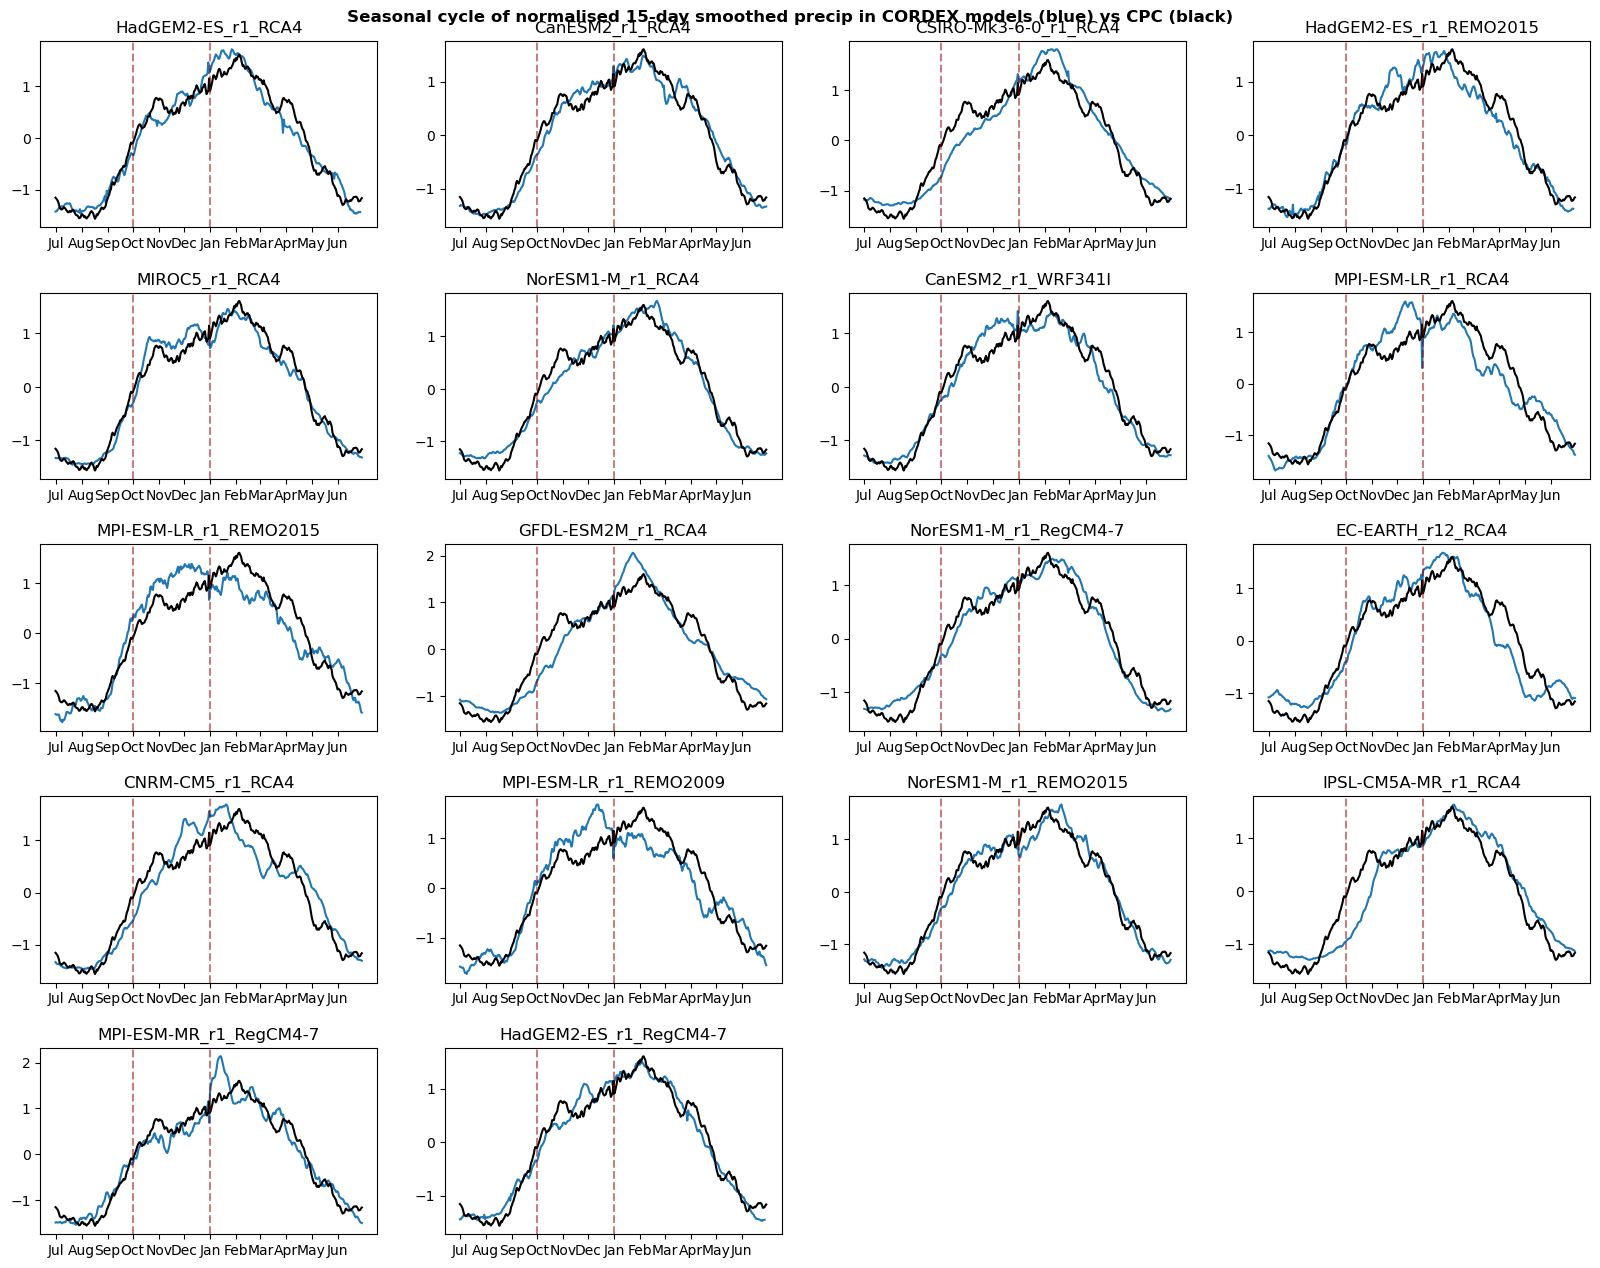

In [62]:
obs = xr.open_dataset("data/cpc_CSA_daily.nc").precip.rolling(time = 15, center = True).mean().groupby("time.dayofyear").mean()
obs = obs.reindex(dayofyear = obs.dayofyear.sortby((obs.dayofyear + y_offset(months = 7)) % 366))

models = [xr.open_dataset(fnm).pr.expand_dims(model = [cordex_model(fnm)]) for fnm in glob.glob("data/pr_SAM-*sc*")]
nr = int(np.ceil(len(models)/4))

wy_dates = xr.open_dataset("data/cpc_CSA_daily.nc").precip.sel(time = slice("2019-07-01", "2020-06-30")).time

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig, axs = plt.subplots(ncols = 4, nrows = nr, figsize = (20,3*nr + 0.5), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

for i in range(len(models)):
    ax = fig.axes[i]
    pr = models[i].squeeze()
    
    pr = pr.reindex(dayofyear = pr.dayofyear.sortby((pr.dayofyear + y_offset(months = 7)) % 366))
    ax.plot((pr - pr.mean()) / pr.std())
    ax.plot((obs - obs.mean()) / obs.std(), label = "CPC", color = "k")
    ax.set_title(pr.model.values)
    [ax.axvline((datetime(2020,m,1).timetuple().tm_yday + y_offset(months = 7)) % 366, ls = "--", color = "darkred", alpha = 0.5) for m in [10,1]]
    sc_xlabels(wy_dates, ax = ax)

for i in range(len(models), len(fig.axes)): fig.axes[i].set_axis_off()

fig.suptitle("Seasonal cycle of normalised 15-day smoothed precip in CORDEX models (blue) vs CPC (black)", fontweight = "bold", y = 0.9)
plt.savefig("cordex_pr_seasonal-cycle.png")

#### **Temperatures**

In [8]:
obs = pd.read_csv("data/cpc-tas-doy.txt", index_col = "dayofyear").to_xarray().tmean
obs = obs.reindex(dayofyear = obs.dayofyear.sortby((obs.dayofyear + y_offset(months = 7)) % 366))

models = [xr.open_dataset(fnm).tas.expand_dims(model = [cordex_model(fnm)]) for fnm in glob.glob("data/tas_SAM-*sc*")]
nr = int(np.ceil(len(models)/4))

wy_dates = xr.open_dataset("data/cpc_CSA_daily.nc").precip.sel(time = slice("2019-07-01", "2020-06-30")).time

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig, axs = plt.subplots(ncols = 4, nrows = nr, figsize = (20,3*nr + 0.5), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

for i in range(len(models)):
    ax = fig.axes[i]
    pr = models[i].squeeze()
    
    pr = pr.reindex(dayofyear = pr.dayofyear.sortby((pr.dayofyear + y_offset(months = 7)) % 366))
    ax.plot((pr - pr.mean()) / pr.std(), color = "tab:orange")
    ax.plot((obs - obs.mean()) / obs.std(), label = "CPC", color = "k")
    ax.set_title(pr.model.values)
    [ax.axvline((datetime(2020,m,1).timetuple().tm_yday + y_offset(months = 7)) % 366, ls = "--", color = "darkred", alpha = 0.5) for m in [10,1]]
    sc_xlabels(wy_dates, ax = ax)

for i in range(len(models), len(fig.axes)): fig.axes[i].set_axis_off()

fig.suptitle("Seasonal cycle of normalised 5-day smoothed temperatures in CORDEX models (orange) vs CPC (black)", fontweight = "bold", y = 0.93)
plt.savefig("cordex_tas_seasonal-cycle.png")

### **Spatial pattern**

#### **Precip**

In [97]:
obs = [xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip.rolling(time = 3).mean().groupby("time.month")[12].dropna("time", "all").sel(time = slice("1980", None)).mean("time").expand_dims(dataset = [ens]) for ens in ["chirps", "cpc", "mswep"]]
obs[2] = obs[2].sel(lat = slice(-50,-10), lon = slice(-80,-40))

models = [wrap_lon(xr.open_dataset(fnm).expand_dims(model = [cordex_model(fnm)]).pr) for fnm in glob.glob("data/pr_SAM-*spatial*.nc")]
models = [m.sel(rlat = np.logical_and(m.lat >= -50, m.lat <= -10).sum(axis = 1) > 0, rlon = np.logical_and(m.lon >= -80, m.lon <= -40).sum(axis = 0) > 0) if "rlat" in m.dims else m for m in models]
models = [m.sel(y = np.logical_and(m.lat >= -50, m.lat <= -10).sum(axis = 1) > 0, x = np.logical_and(m.lon >= -80, m.lon <= -40).sum(axis = 0) > 0) if "x" in m.dims else m for m in models]
models = [m.dropna(m.dims[1], "all").dropna(m.dims[2], "all") for m in models]
nr = int(np.ceil(len(models)/4)) + 1

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

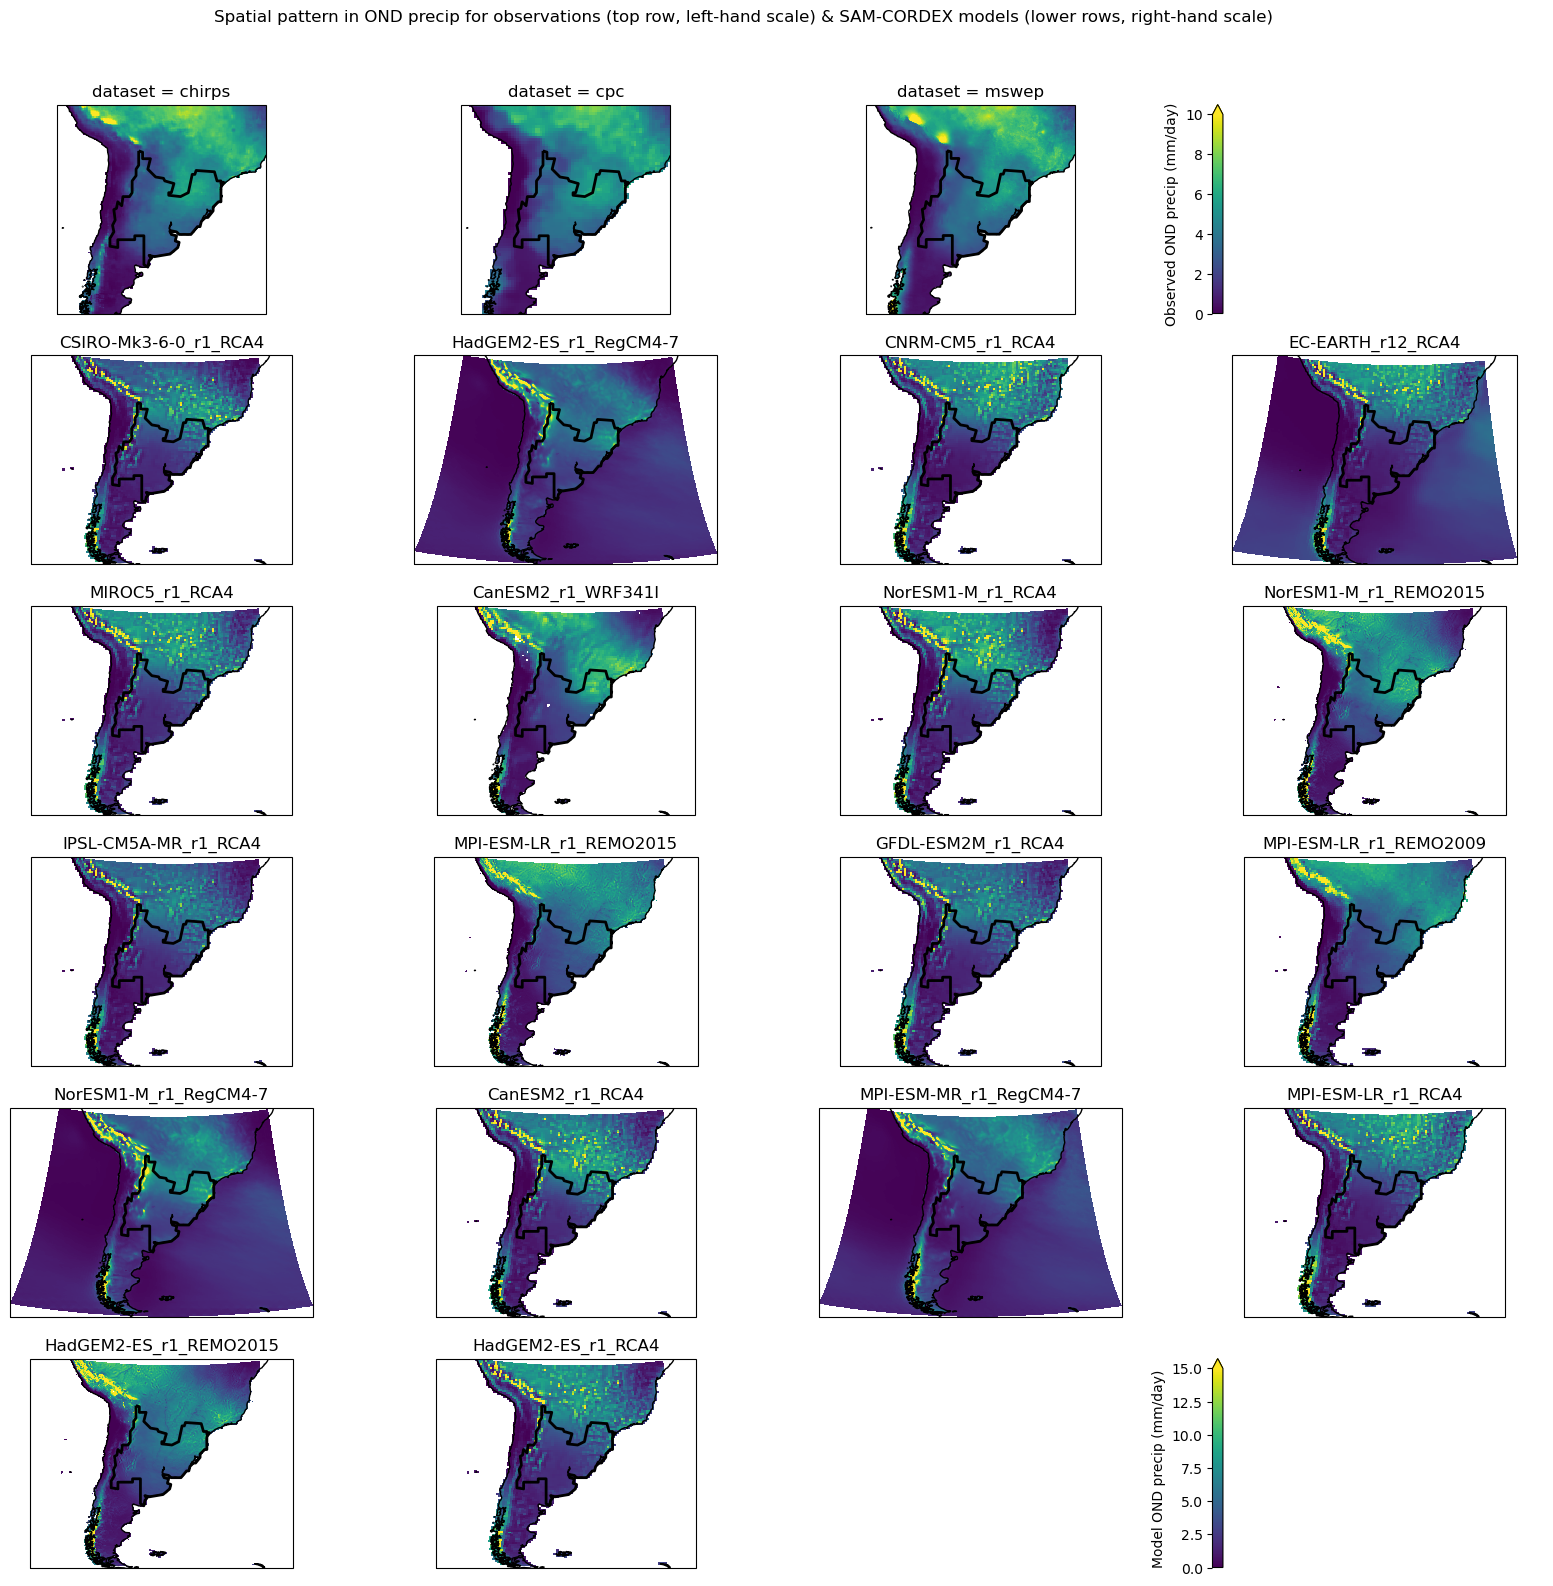

In [98]:
fig, axs = plt.subplots(ncols = 4, nrows = nr, figsize = (20,3*nr + 1), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

obs_kwargs = {"vmin" : 0, "vmax" : 10, "add_colorbar" : False}
model_kwargs = {"vmin" : 0, "vmax" : 15}

axs[0,3].set_axis_off()
for i in range(len(obs)):
    ax = axs[0,i]
    cbar_obs = obs[i].plot(ax = ax, **obs_kwargs)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)
    
for i in range(len(models)):
    ax = fig.axes[i+4]
    pr = models[i].squeeze()
    cbar_mdl = ax.pcolormesh(pr.lon, pr.lat, pr, **model_kwargs)
    ax.set_title(pr.model.values)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)

for i in range(len(models)+4,4*nr):
    fig.axes[i].set_axis_off()

plt.colorbar(cbar_obs, ax = axs[0,3], location = "left", fraction = 0.05, extend = "max", label = "Observed OND precip (mm/day)")
plt.colorbar(cbar_mdl, ax = axs[-1,3], location = "left", fraction = 0.05, extend = "max", label = "Model OND precip (mm/day)")

plt.suptitle("Spatial pattern in OND precip for observations (top row, left-hand scale) & SAM-CORDEX models (lower rows, right-hand scale)", y = 0.93)
plt.savefig("cordex_pr-ond_spatial-patterns.png")

#### **Temperatures**

In [10]:
cpc = xr.open_dataset("data/cpc_tas_monthly.nc").tas.rolling(time = 3).mean().groupby("time.month")[1].dropna("time", "all").sel(time = slice("1980", None)).mean("time")

models = [wrap_lon(xr.open_dataset(fnm).expand_dims(model = [cordex_model(fnm)]).tas) for fnm in glob.glob("data/tas_SAM-*spatial*.nc")]
models = [m.sel(rlat = np.logical_and(m.lat >= -50, m.lat <= -10).sum(axis = 1) > 0, rlon = np.logical_and(m.lon >= -80, m.lon <= -40).sum(axis = 0) > 0) if "rlat" in m.dims else m for m in models]
models = [m.sel(y = np.logical_and(m.lat >= -50, m.lat <= -10).sum(axis = 1) > 0, x = np.logical_and(m.lon >= -80, m.lon <= -40).sum(axis = 0) > 0) if "x" in m.dims else m for m in models]
models = [m.dropna(m.dims[1], "all").dropna(m.dims[2], "all") for m in models]
nr = int(np.ceil(len(models)/4)) + 1

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

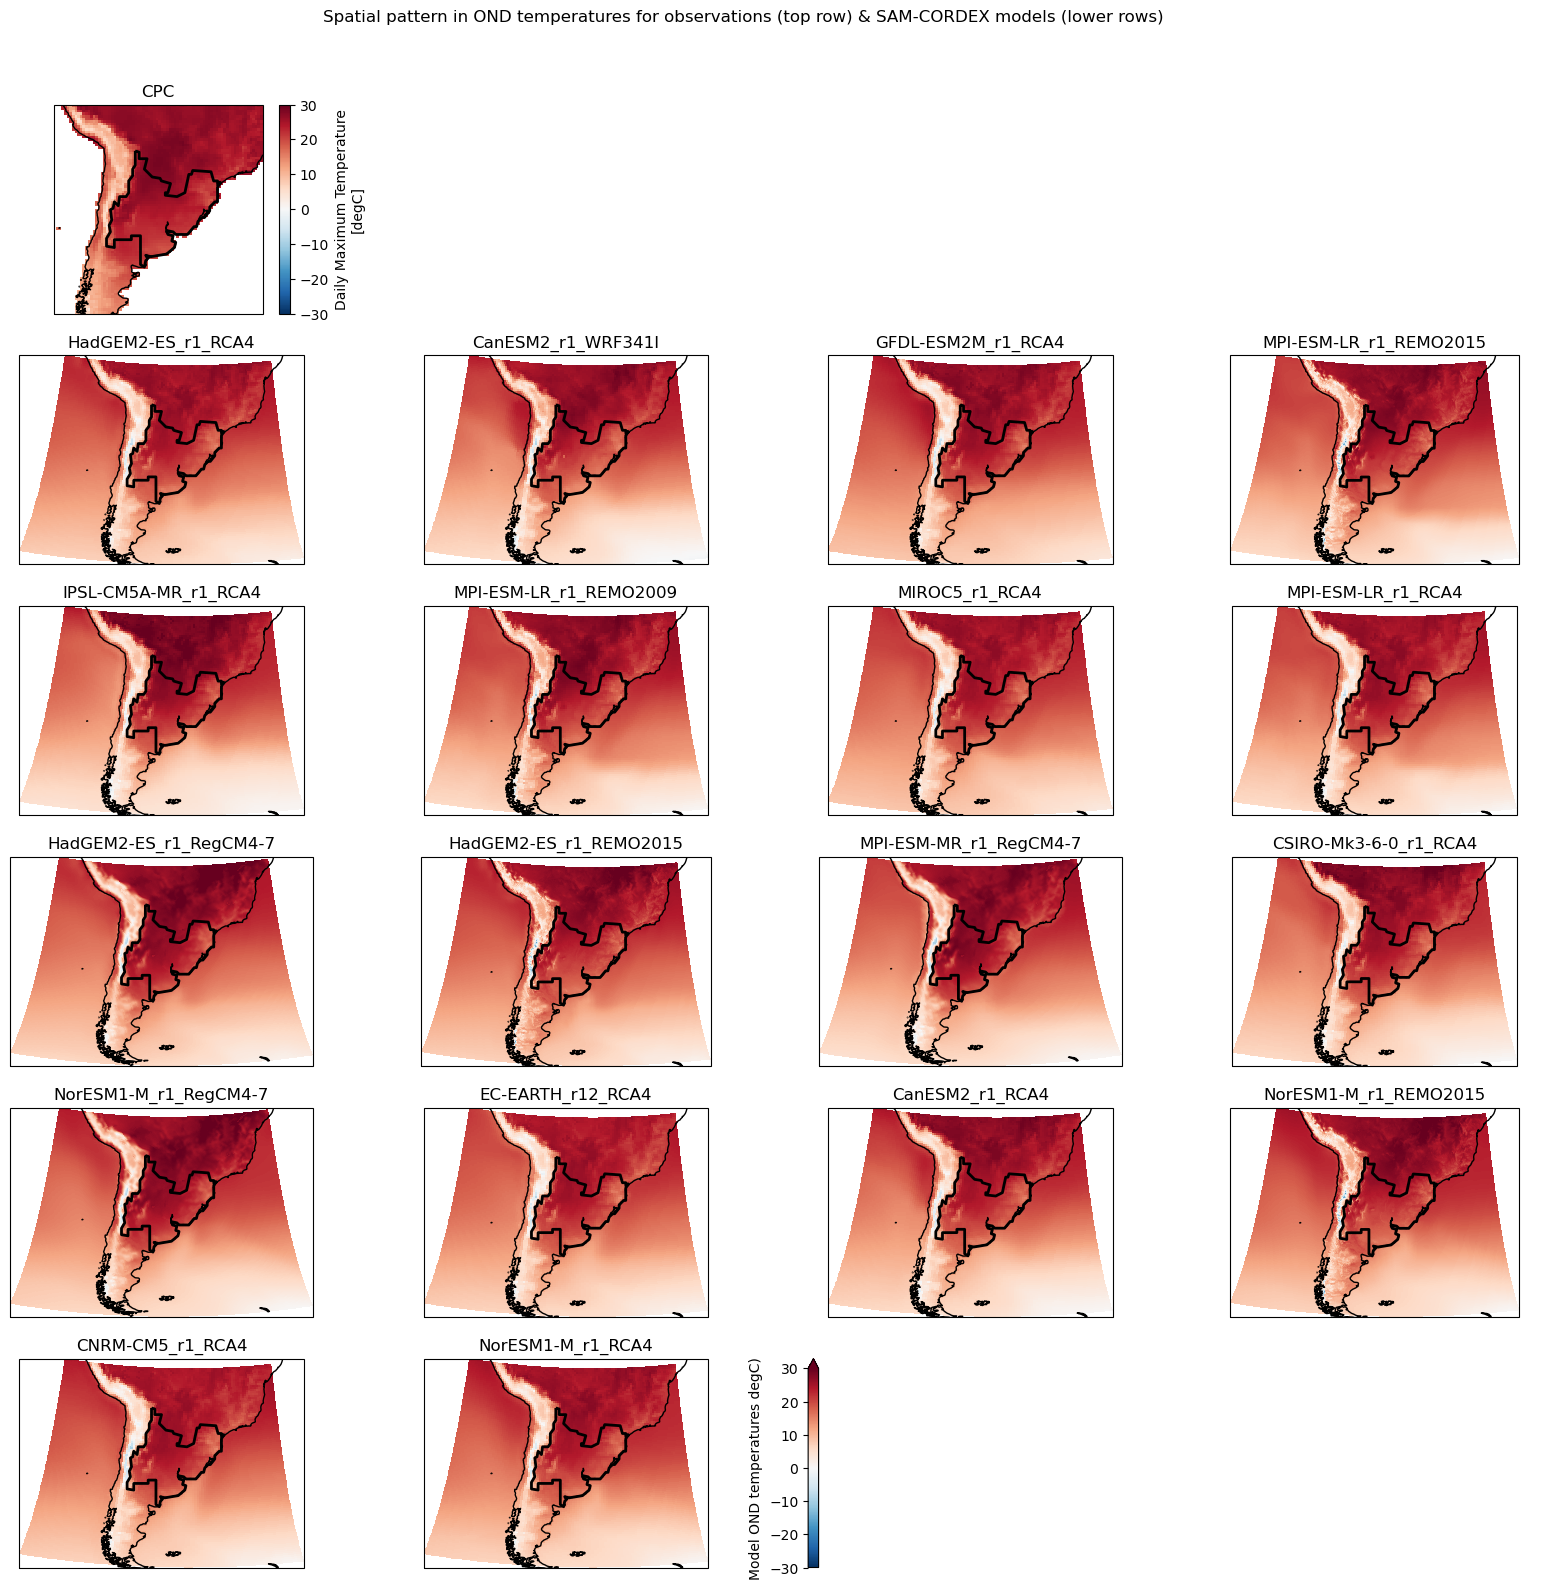

In [11]:
fig, axs = plt.subplots(ncols = 4, nrows = nr, figsize = (20,3*nr + 1), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

plot_kwargs = {"vmin" : -30, "vmax" : 30, "cmap" : "RdBu_r"}

for ax in axs[0,1:]: ax.set_axis_off()
cpc.plot(ax = axs[0,0], **plot_kwargs)
axs[0,0].coastlines()
axs[0,0].set_title("CPC")
sf.boundary.plot(ax = axs[0,0], color = "k", lw = 2)
    
for i in range(len(models)):
    ax = fig.axes[i+4]
    pr = models[i].squeeze()
    cbar_mdl = ax.pcolormesh(pr.lon, pr.lat, pr, **plot_kwargs)
    ax.set_title(pr.model.values)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)

for i in range(len(models)+4,4*nr):
    fig.axes[i].set_axis_off()

plt.colorbar(cbar_mdl, ax = axs[-1,2], location = "left", fraction = 0.05, pad = -0.5, extend = "max", label = "Model OND temperatures degC)")

plt.suptitle("Spatial pattern in OND temperatures for observations (top row) & SAM-CORDEX models (lower rows)", y = 0.93)
plt.savefig("cordex_tas-ond_spatial-patterns.png")

### **Distribution of OND precip**


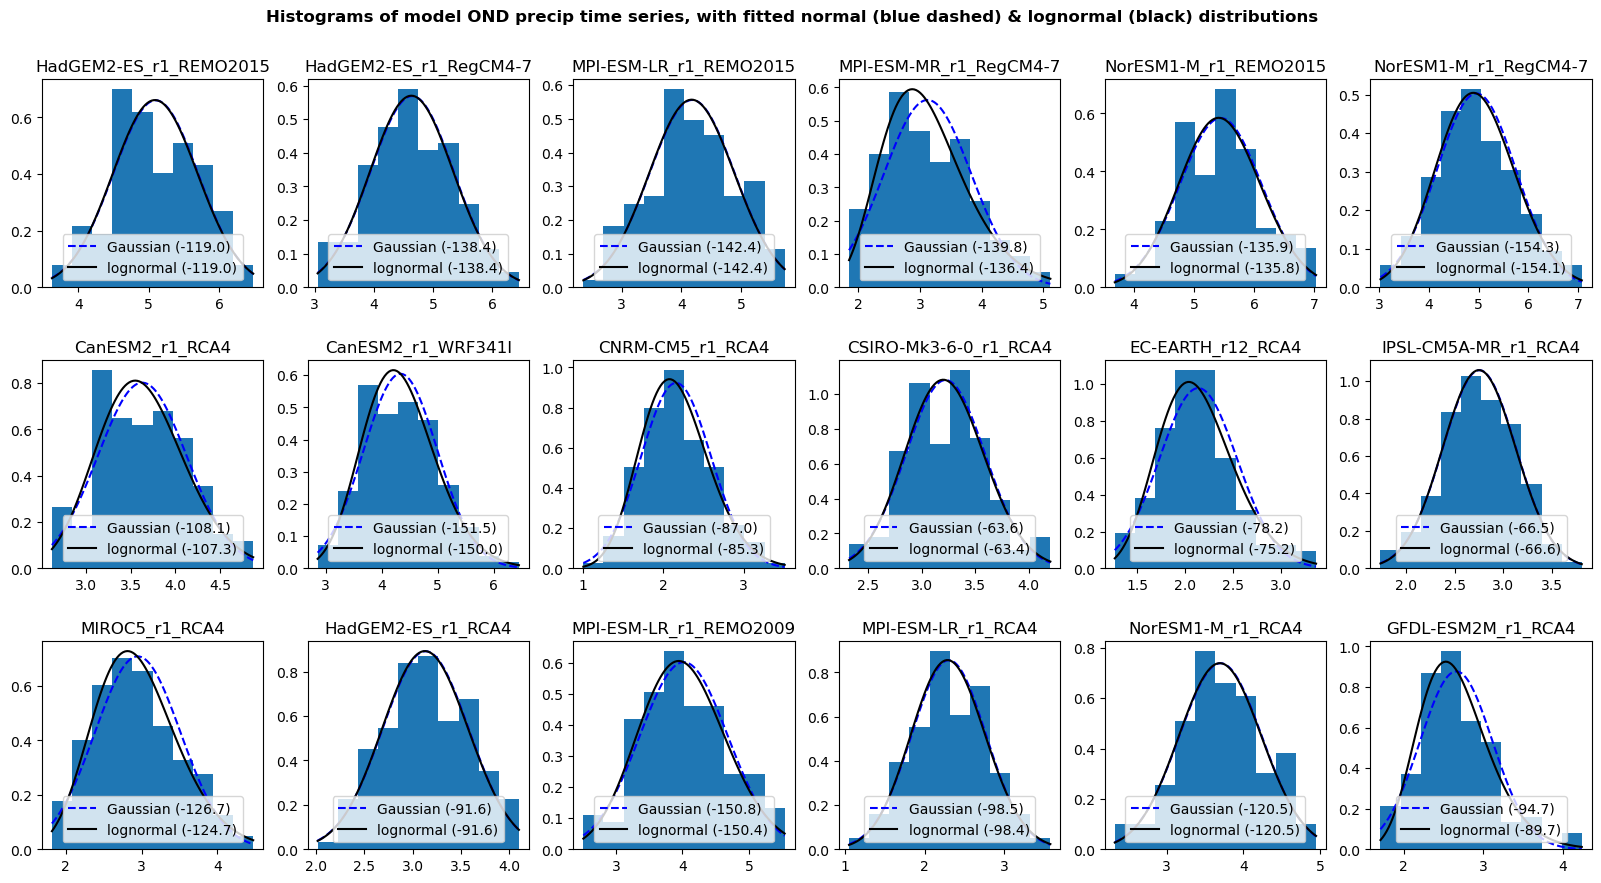

In [162]:
fl = sorted(glob.glob("ts/*pr-ond_SAM-*"))
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (20,10), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

for i in range(len(fl)):
    
    fnm = fl[i]
    ax = fig.axes[i]
    
    df = pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    df = df.loc[~np.isnan(df.precip)]
    x = np.linspace(df.min(), df.max(), 100)
    ax.plot(x, norm.pdf(x, *norm.fit(df)), color = "blue", label = "Gaussian ("+str(np.log(norm.pdf(df, *norm.fit(df))).sum().round(1))+")", ls = "--")
    ax.plot(x, lognorm.pdf(x, *lognorm.fit(df)), color = "k", label = "lognormal ("+str(np.log(lognorm.pdf(df, *lognorm.fit(df))).sum().round(1))+")")
    
    ax.hist(df, density = True)
    ax.set_title(cordex_model(re.sub(".dat", "", re.sub(".+CSA-drought_", "", fnm))))
    ax.legend(loc = "lower center")
    
for i in range(len(fl), len(fig.axes)):
    fig.axes[i].set_axis_off()
    
plt.suptitle("Histograms of model OND precip time series, with fitted normal (blue dashed) & lognormal (black) distributions", y = 0.95, fontweight = "bold")
plt.savefig("cordex_pr-ond_check-distributions.png")

### **Distribution of OND CWB**

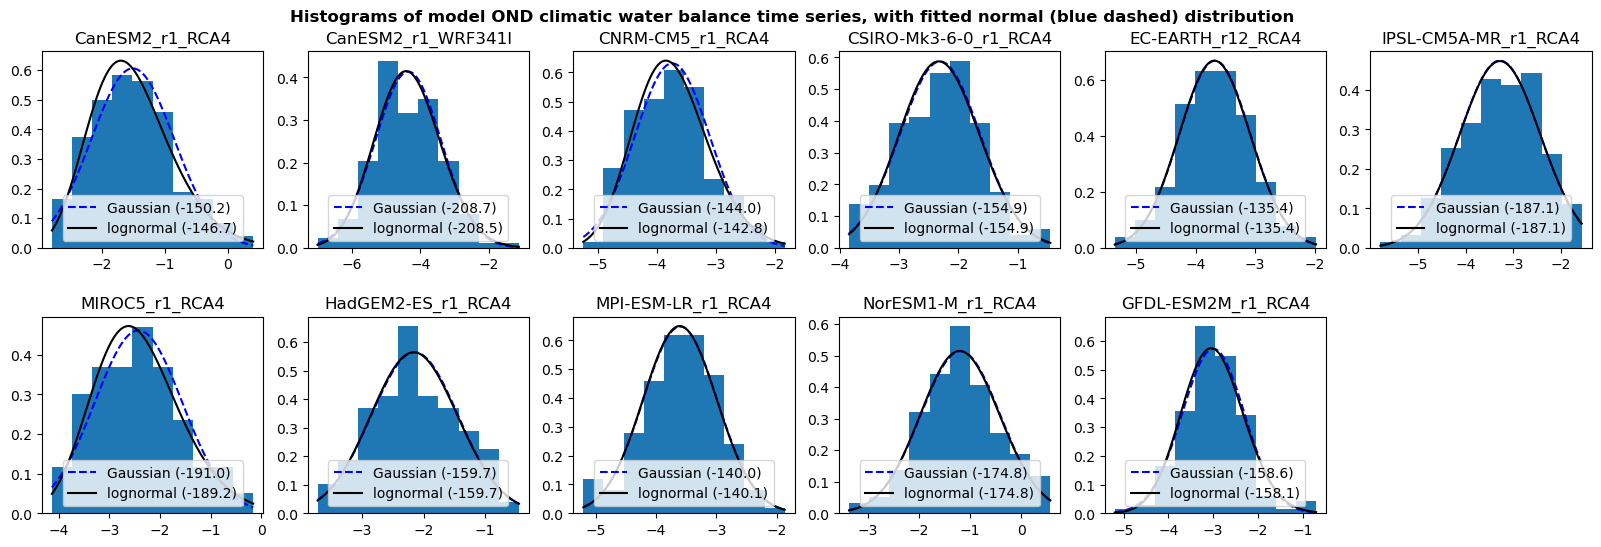

In [217]:
fl = sorted(glob.glob("ts/*cwb-ond_SAM-*"))

fig, axs = plt.subplots(ncols = 6, nrows = 2, figsize = (20,6), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

for i in range(len(fl)):
    
    fnm = fl[i]
    ax = fig.axes[i]
    
    df = pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", "cwb"], index_col = "year")
    df = df.loc[~np.isnan(df.cwb)]
    x = np.linspace(df.min(), df.max(), 100)
    ax.plot(x, norm.pdf(x, *norm.fit(df)), color = "blue", label = "Gaussian ("+str(np.log(norm.pdf(df, *norm.fit(df))).sum().round(1))+")", ls = "--")
    ax.plot(x, lognorm.pdf(x, *lognorm.fit(df)), color = "k", label = "lognormal ("+str(np.log(lognorm.pdf(df, *lognorm.fit(df))).sum().round(1))+")")
    
    ax.hist(df, density = True)
    ax.set_title(cordex_model(re.sub(".dat", "", re.sub(".+CSA-drought_", "", fnm))))
    ax.legend(loc = "lower center")
    
for i in range(len(fl), len(fig.axes)):
    fig.axes[i].set_axis_off()
    
plt.suptitle("Histograms of model OND climatic water balance time series, with fitted normal (blue dashed) distribution", y = 0.95, fontweight = "bold")
plt.savefig("cordex_cwb-ond_check-distributions.png")

### **Distribution of OND tas**

In [4]:
fl = sorted(glob.glob("ts/*tas-ond_SAM-*"))

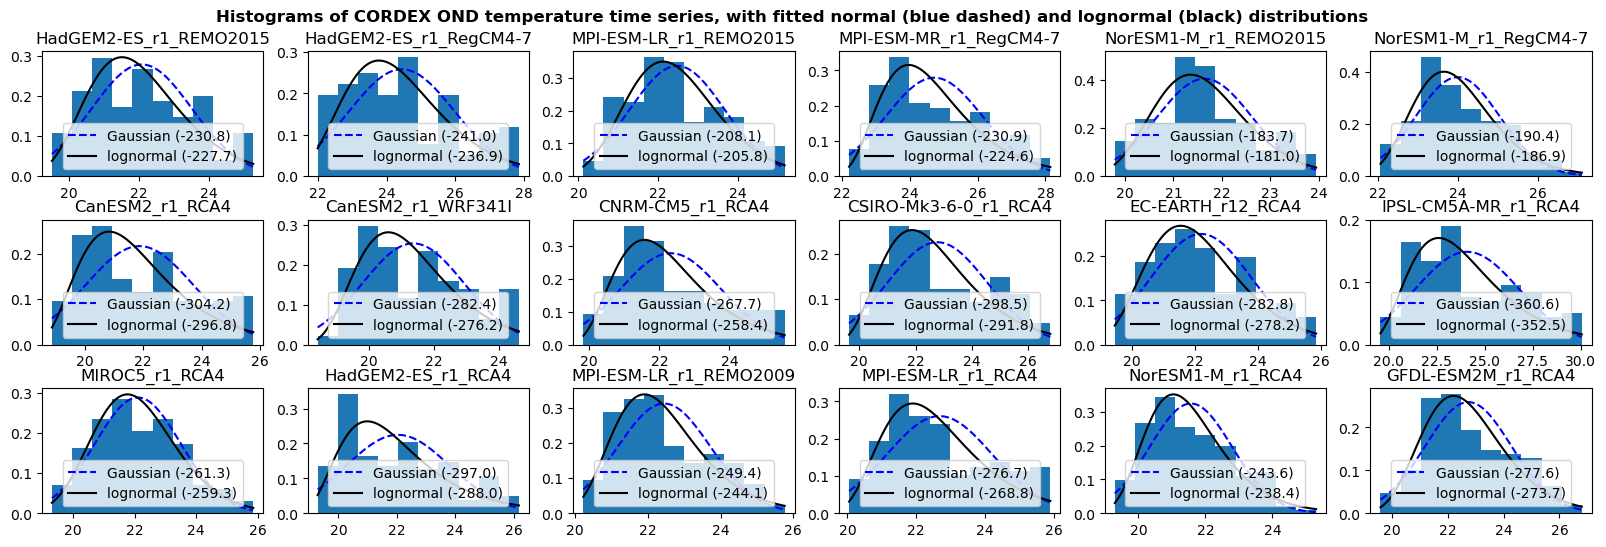

In [7]:
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (20,6), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

for i in range(len(fl)):
    
    fnm = fl[i]
    ax = fig.axes[i]
    
    df = pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", "tas"], index_col = "year")
    df = df.loc[~np.isnan(df.tas)]
    x = np.linspace(df.min(), df.max(), 100)
    ax.plot(x, norm.pdf(x, *norm.fit(df)), color = "blue", label = "Gaussian ("+str(np.log(norm.pdf(df, *norm.fit(df))).sum().round(1))+")", ls = "--")
    ax.plot(x, lognorm.pdf(x, *lognorm.fit(df)), color = "k", label = "lognormal ("+str(np.log(lognorm.pdf(df, *lognorm.fit(df))).sum().round(1))+")")
    
    ax.hist(df, density = True)
    ax.set_title(cordex_model(re.sub(".dat", "", re.sub(".+CSA-drought_", "", fnm))))
    ax.legend(loc = "lower center")
    
for i in range(len(fl), len(fig.axes)):
    fig.axes[i].set_axis_off()
    
plt.suptitle("Histograms of CORDEX OND temperature time series, with fitted normal (blue dashed) and lognormal (black) distributions", y = 0.95, fontweight = "bold")
plt.savefig("cordex_tas-ond_check-distributions.png")

### **Distribution of OND mrso**

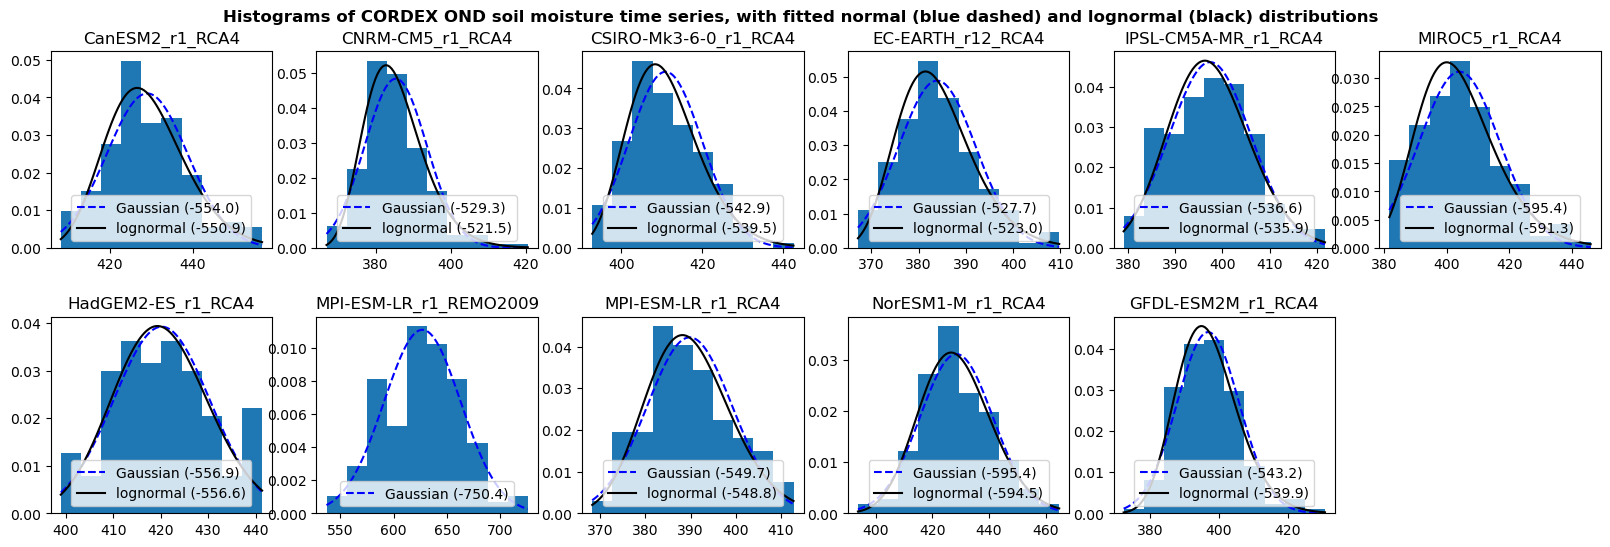

In [13]:
fig, axs = plt.subplots(ncols = 6, nrows = 2, figsize = (20,6), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

for i in range(len(fl)):
    
    fnm = fl[i]
    ax = fig.axes[i]
    
    df = pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", "mrso"], index_col = "year")
    df = df.loc[~np.isnan(df.mrso)]
    x = np.linspace(df.min(), df.max(), 100)
    ax.plot(x, norm.pdf(x, *norm.fit(df)), color = "blue", label = "Gaussian ("+str(np.log(norm.pdf(df, *norm.fit(df))).sum().round(1))+")", ls = "--")
    if not "REMO" in fnm:
        ax.plot(x, lognorm.pdf(x, *lognorm.fit(df)), color = "k", label = "lognormal ("+str(np.log(lognorm.pdf(df, *lognorm.fit(df))).sum().round(1))+")")
    
    ax.hist(df, density = True)
    ax.set_title(cordex_model(re.sub(".dat", "", re.sub(".+CSA-drought_", "", fnm))))
    ax.legend(loc = "lower center")
    
for i in range(len(fl), len(fig.axes)):
    fig.axes[i].set_axis_off()
    
plt.suptitle("Histograms of CORDEX OND soil moisture time series, with fitted normal (blue dashed) and lognormal (black) distributions", y = 0.95, fontweight = "bold")
plt.savefig("cordex_mrso-ond_check-distributions.png")

---
## **Trends in related variables**

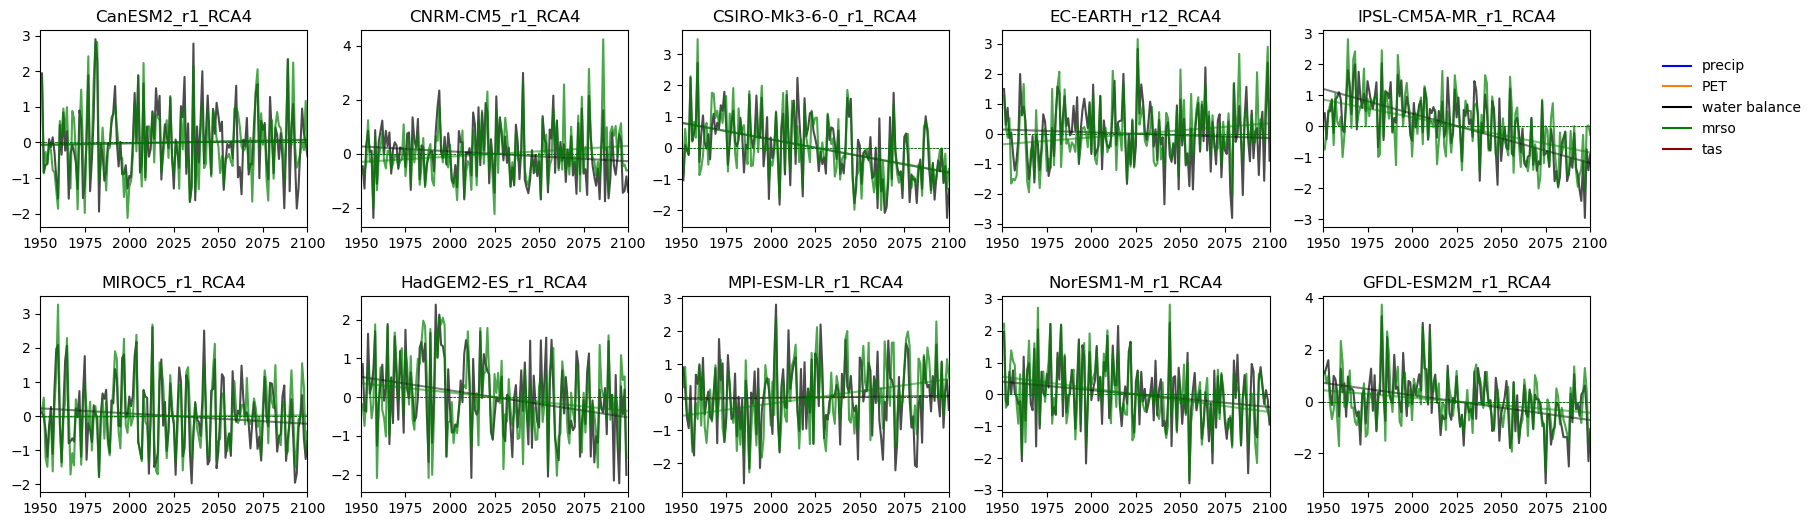

In [49]:
fl = sorted(glob.glob("ts/*cwb-ond_SAM-*"))
def scale(ts): return((ts - ts.mean()) / ts.std())

fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (20,6), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

corrs = []
for i in range(len(fl)):
    
    fnm = fl[i]
    ax = fig.axes[i]
    
    df = scale(pd.read_csv(re.sub("cwb", "pr", fnm), comment = "#", sep = " ", header = None, names = ["year", "pr"], index_col = "year"))
    df["cwb"] = scale(pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", "cwb"], index_col = "year")["cwb"])
    df["pet"] = scale(pd.read_csv(re.sub("cwb", "pet", fnm), comment = "#", sep = " ", header = None, names = ["year", "pet"], index_col = "year")["pet"])
    df["mrso"] = scale(pd.read_csv(re.sub("cwb", "mrso", fnm), comment = "#", sep = " ", header = None, names = ["year", "mrso"], index_col = "year")["mrso"])
    df["tas"] = scale(pd.read_csv(re.sub("cwb", "tas", fnm), comment = "#", sep = " ", header = None, names = ["year", "tas"], index_col = "year")["tas"]) # shifted for ease of plotting

    corrs.append(df.corr())

#     ax.plot(df.pr, color = "blue", alpha = 0.7)
#     ax.axhline(df.pr.mean(),color = "blue", lw = 0.5, ls = "--")
#     ax.plot(df.index, np.poly1d(np.polyfit(df.index, df.pr, 1))(df.index), color = "blue")
        
#     ax.plot(df.pet, color = "tab:orange", alpha = 0.7)
#     ax.axhline(df.pet.mean(), color = "tab:orange", lw = 0.5, ls = "--")
#     ax.plot(df.index, np.poly1d(np.polyfit(df.index, df.pet, 1))(df.index), color = "tab:orange", alpha = 0.5)
    
#     ax.plot(df.tas, color = "darkred", alpha = 0.7)
#     ax.axhline(df.tas.mean(),color = "darkred", lw = 0.5, ls = "--")
#     ax.plot(df.index, np.poly1d(np.polyfit(df.index, df.tas, 1))(df.index), color = "darkred")
    
    ax.plot(df.cwb, color = "k", alpha = 0.7)
    ax.axhline(df.cwb.mean(), color = "k", lw = 0.5, ls = "--")
    ax.plot(df.index, np.poly1d(np.polyfit(df.index, df.cwb, 1))(df.index), color = "k", alpha = 0.5)
    
    ax.plot(df.mrso, color = "green", alpha = 0.7)
    ax.axhline(df.mrso.mean(), color = "green", lw = 0.5, ls = "--")
    ax.plot(df.index, np.poly1d(np.polyfit(df.index, df.mrso, 1))(df.index), color = "green", alpha = 0.5)


    ax.set_title(cordex_model(re.sub(".dat", "", re.sub(".+CSA-drought_", "", fnm))))
    ax.set_xlim(1950,2100)
    
fig.legend(handles = [matplotlib.lines.Line2D([], [], color = c, label = l) for c, l in zip(["blue", "tab:orange", "k", "green", "darkred"], ["precip", "PET", "water balance", "mrso", "tas"])], 
           loc = "center left", edgecolor = "w", bbox_to_anchor = (0.93, 0.75))

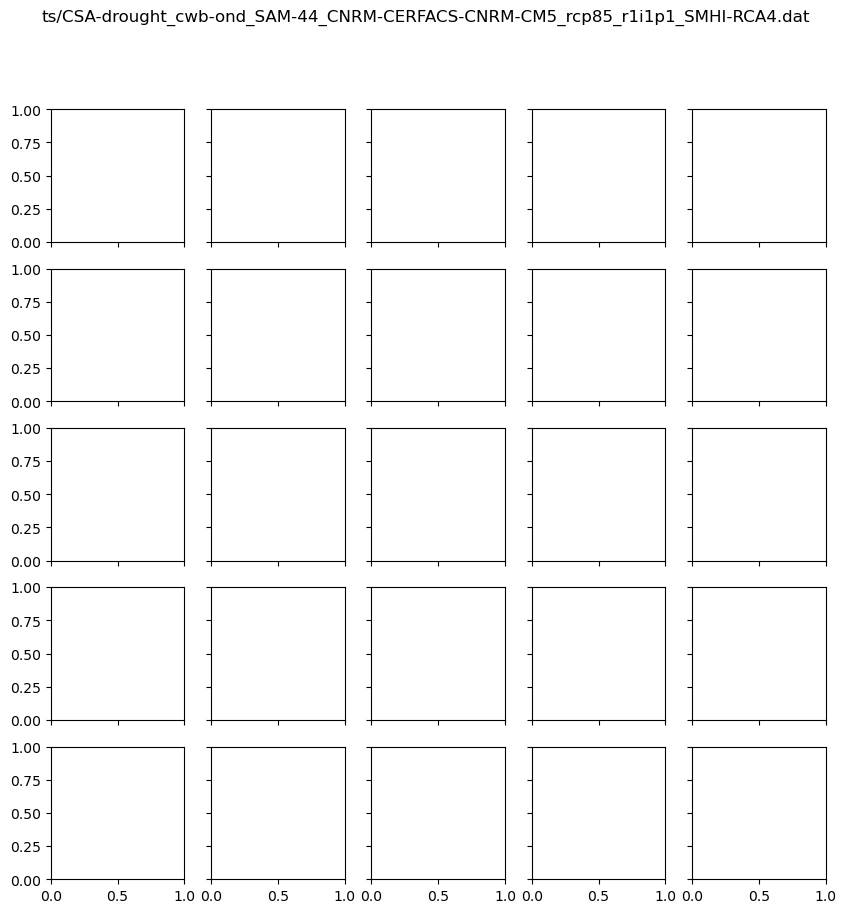

In [91]:
fl = sorted(glob.glob("ts/*cwb-ond_SAM-*"))

fig, axs = plt.subplots(ncols = 5, nrows = 5, sharex = "col", sharey = "row", figsize = (10,10), dpi = 100)
plt.s
for i in range(len(fl))[:2]:
    
    fnm = fl[i]
    
    df = scale(pd.read_csv(re.sub("cwb", "pr", fnm), comment = "#", sep = " ", header = None, names = ["year", "pr"], index_col = "year"))
    df["mrso"] = scale(pd.read_csv(re.sub("cwb", "mrso", fnm), comment = "#", sep = " ", header = None, names = ["year", "mrso"], index_col = "year")["mrso"])
    df["cwb"] = scale(pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", "cwb"], index_col = "year")["cwb"])
    df["pet"] = scale(pd.read_csv(re.sub("cwb", "pet", fnm), comment = "#", sep = " ", header = None, names = ["year", "pet"], index_col = "year")["pet"])
    df["tas"] = scale(pd.read_csv(re.sub("cwb", "tas", fnm), comment = "#", sep = " ", header = None, names = ["year", "tas"], index_col = "year")["tas"]) # shifted for ease of plotting

    # axs = pd.plotting.scatter_matrix(df)
    plt.suptitle(fnm)
    
    # corr = df.corr().to_numpy()
    # for i,j in [range(5), range(5)]:
    #     axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')


In [54]:
c = corrs[0]
c

pr       cwb       pet      mrso       tas
pr    1.000000  0.856250 -0.191416  0.702479  0.392930
cwb   0.856250  1.000000 -0.670910  0.813633 -0.108388
pet  -0.191416 -0.670910  1.000000 -0.537540  0.770006
mrso  0.702479  0.813633 -0.537540  1.000000 -0.062864
tas   0.392930 -0.108388  0.770006 -0.062864  1.000000

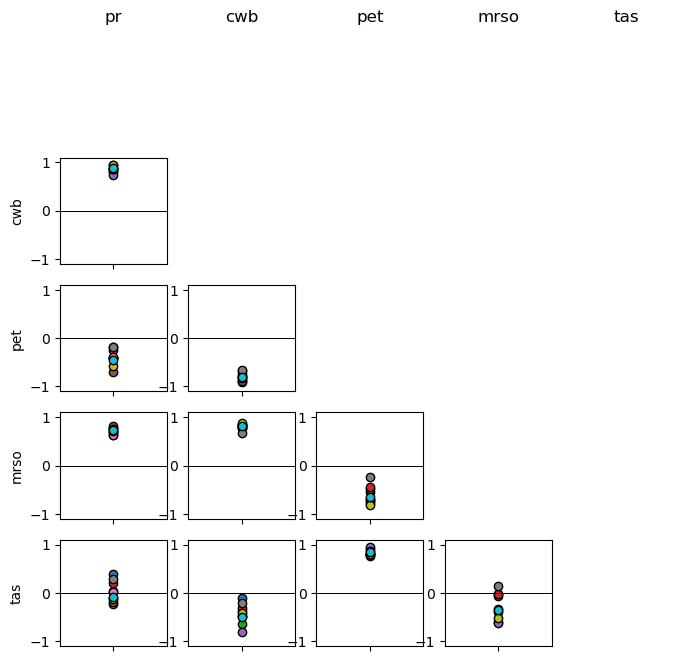

In [90]:
fig,axs = plt.subplots(ncols = 5, nrows = 5, figsize = (8,8), dpi = 100)

for c in corrs:
    
    for i in range(5):
        axs[0,i].set_title(["pr","cwb","pet","mrso","tas"][i])
        axs[i,0].set_ylabel(["pr","cwb","pet","mrso","tas"][i])
        for j in range(5):
            if i > j:
                axs[i,j].plot(c.iloc[i,j], marker = "o", mec = "k")
                axs[i,j].axhline(0,color = "k", alpha = 0.5, lw = 0.5)
            else:
                axs[i,j].set_axis_off()
        
for ax in fig.axes: 
    ax.set_ylim(-1.1,1.1)
    ax.set_xticks([0]); ax.set_xticklabels([""])
    


---
## **UKCP18**

### **Extract time series, spatial pattern & seasonal cycle**

_Run on Jasmin:_

```
# load shapefile defining study region
sf = gpd.read_file("11_wwa/23-01_CSA-drought/sf_CSA-drought/")

# define extent of area used to check spatial pattern
lon_slice = slice(-85,-40); lat_slice = slice(-50,-10)

# define time periods used: observed & extended (use all past data for model analysis)
obs_slice = slice("1980", "2022"); model_slice = slice(None, "2050")

# loop over the UKCP runs
for fpath in glob.glob("/badc/ukcp18/data/land-gcm/global/60km/rcp85/*")[:15]:

    new_fnm = "/home/users/clairb/11_wwa/23-01_CSA-drought/tas_ukcp-land-gcm_"+fpath.split("/")[-1]+"_rcp85_"
    
    sp_fnm = new_fnm+"spatial_1980-2022.nc"
    sc_fnm = new_fnm+"seasonal_1980-2022.nc"
    ts_fnm = new_fnm+"ts_1900-2050.nc"
    
    if exists(sp_fnm) and exists(sc_fnm) and exists(ts_fnm): continue

    da = convert_calendar(xr.open_mfdataset(fpath+"/tas/day/latest/*.nc").tas.reset_coords(drop = True).sel(longitude = lon_slice, latitude = lat_slice).sel(time = slice("1900", None)),
                          "default", align_on = "date")
    
    rm = regionmask.mask_3D_geopandas(sf, da.longitude, da.latitude, drop = False).squeeze(drop = True)
    
    da_ond = da.resample(time = "QS-JAN").mean().groupby("time.month")[10]

    # seasonal cycle: day-of-year average, averaged over shapefile, for obs period
    seasonal = da.where(rm).mean(["latitude", "longitude"]).rolling(time = 15).mean().sel(time = obs_slice).groupby("time.dayofyear").mean()
    seasonal.to_netcdf(sc_fnm)

    # spatial pattern: annual maxima, averaged over all years in obs period
    spatial = da_ond.sel(time = obs_slice).mean("time")
    spatial.to_netcdf(sp_fnm)

    # time series for analysis: annual maxima, averaged over shapefile, for longer period
    ts = da_ond.where(rm).mean(["latitude", "longitude"]).sel(time = model_slice)
    ts.to_netcdf(ts_fnm)
```

### **Convert netcdf to time series**


In [108]:
for fnm in sorted(glob.glob("data/pr_ukcp*_*ts_*.nc")):
    
    csv_fnm = "ts/CSA-drought_pr-ond_ukcp-land-gcm_"+fnm[22:24]+".dat"

    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: UKCP18 "+mdl+" OND precip central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# precip [mm/day] OND mean precipitation rate at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year precip"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pr_ond = xr.open_dataset(fnm).pr.squeeze(drop = True)
    pr_ond.assign_coords(time = pr_ond.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [154]:
for fnm in sorted(glob.glob("data/tas_ukcp*_*ts_*.nc")):
    
    csv_fnm = "ts/CSA-drought_tas-ond_ukcp-land-gcm_"+fnm[23:25]+".dat"

    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: UKCP18 "+mdl+" OND temperatures central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# tmean [degC] OND mean temperatures at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year precip"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pr_ond = xr.open_dataset(fnm).tas.squeeze(drop = True)
    pr_ond.assign_coords(time = pr_ond.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [52]:
for fnm in sorted(glob.glob("data/mrso_ukcp*_*ts_*.nc")):
    
    csv_fnm = "ts/CSA-drought_mrso-sfc-ond_ukcp-land-gcm_"+fnm[24:26]+".dat"

    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: UKCP18 "+mdl+" OND surface soil moisture central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# mrso [kg m-2] OND mean surface soil moisture at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year mrso"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pr_ond = xr.open_dataset(fnm).mrso.sel(depth = 0.05).squeeze(drop = True).reset_coords(drop = True)
    pr_ond.assign_coords(time = pr_ond.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [53]:
for fnm in sorted(glob.glob("data/mrso_ukcp*_*ts_*.nc")):
    
    csv_fnm = "ts/CSA-drought_mrso-rz-ond_ukcp-land-gcm_"+fnm[24:26]+".dat"

    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: UKCP18 "+mdl+" OND root zone soil moisture central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# mrso [kg m-2] OND mean root zone soil moisture at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year mrso"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pr_ond = xr.open_dataset(fnm).mrso.sel(depth = [0.05, 0.225, 0.675]).mean("depth").squeeze(drop = True).reset_coords(drop = True)
    pr_ond.assign_coords(time = pr_ond.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Seasonal cycle**

#### **Precip**

In [122]:
obs = xr.open_dataset("data/cpc_CSA_daily.nc").precip.rolling(time = 15, center = True).mean().groupby("time.dayofyear").mean()
obs = obs.reindex(dayofyear = obs.dayofyear.sortby((obs.dayofyear + y_offset(months = 7)) % 366))

models = xr.open_mfdataset("data/pr_ukcp*_seasonal*.nc").pr

wy_dates = xr.open_dataset("data/cpc_CSA_daily.nc").precip.sel(time = slice("2019-07-01", "2020-06-30")).time

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig, axs = plt.subplots(ncols = 5, nrows = 3, figsize = (23,8), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

for i in range(len(models)):
    ax = fig.axes[i]
    pr = models[i].squeeze()
    
    pr = pr.reindex(dayofyear = pr.dayofyear.sortby((pr.dayofyear + y_offset(months = 7)) % 366))
    ax.plot((pr - pr.mean()) / pr.std())
    ax.plot((obs - obs.mean()) / obs.std(), label = "CPC", color = "k")
    ax.set_title(pr.ensemble_member.values)
    [ax.axvline((datetime(2020,m,1).timetuple().tm_yday + y_offset(months = 7)) % 366, ls = "--", color = "darkred", alpha = 0.5) for m in [10,1]]
    sc_xlabels(wy_dates, ax = ax)

for i in range(len(models), len(fig.axes)): fig.axes[i].set_axis_off()

fig.suptitle("Seasonal cycle of normalised 15-day smoothed precip in UKCP18 global models (blue) vs CPC (black)", fontweight = "bold", y = 0.98)
plt.savefig("ukcp_pr_seasonal-cycle.png")

#### **Temp**

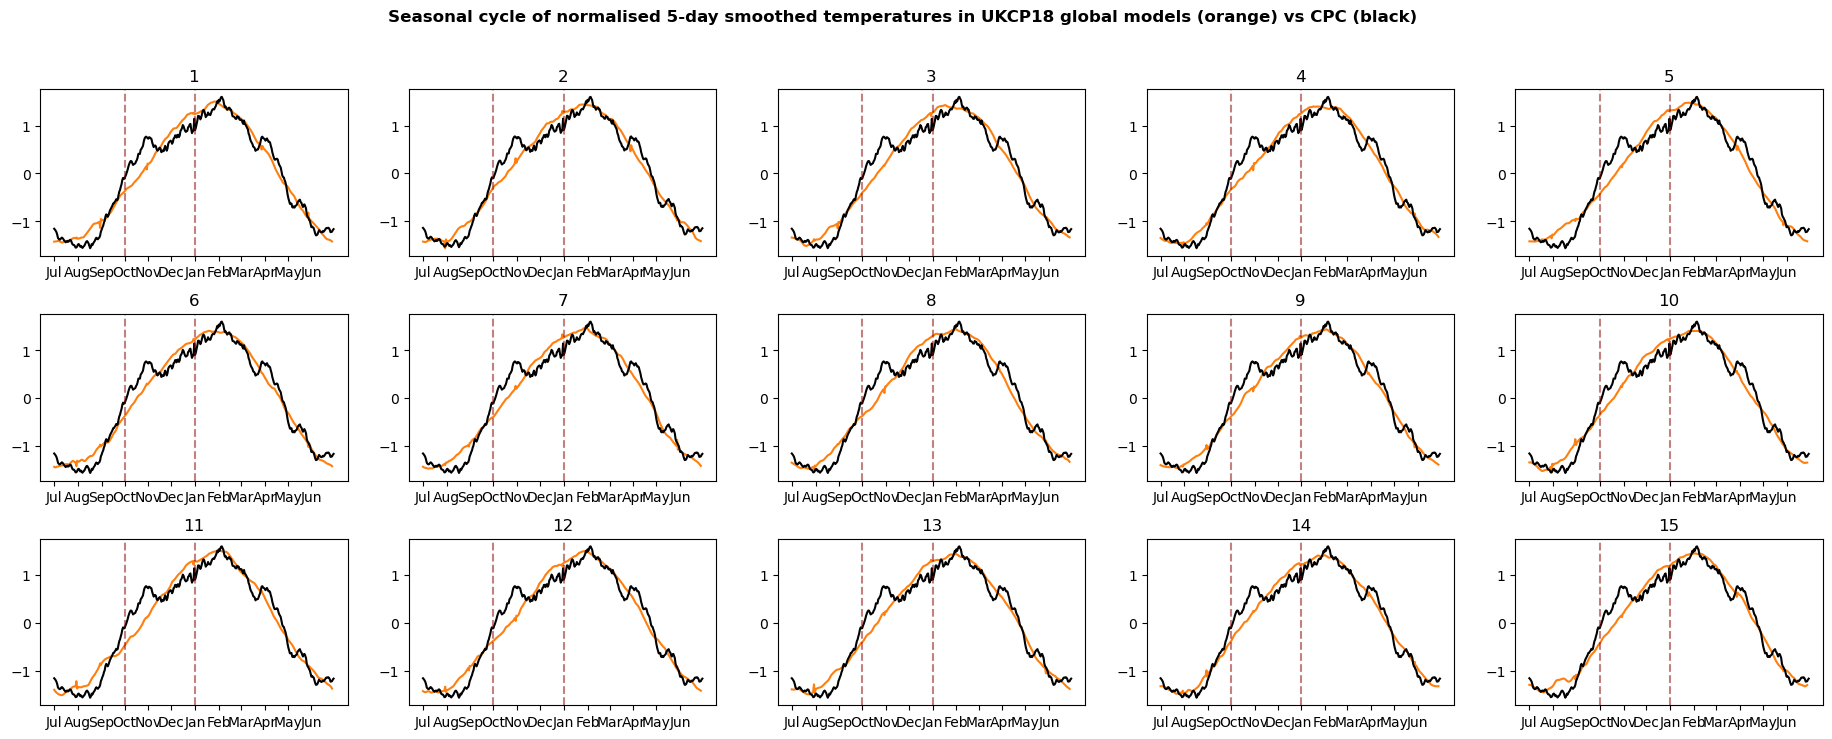

In [139]:
obs = xr.open_dataset("data/cpc_CSA_daily.nc").precip.rolling(time = 15, center = True).mean().groupby("time.dayofyear").mean()
obs = obs.reindex(dayofyear = obs.dayofyear.sortby((obs.dayofyear + y_offset(months = 7)) % 366))

models = xr.open_mfdataset("data/tas_ukcp*_seasonal*.nc").tas

wy_dates = xr.open_dataset("data/cpc_CSA_daily.nc").precip.sel(time = slice("2019-07-01", "2020-06-30")).time

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig, axs = plt.subplots(ncols = 5, nrows = 3, figsize = (23,8), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

for i in range(len(models)):
    ax = fig.axes[i]
    pr = models[i].squeeze()
    
    pr = pr.reindex(dayofyear = pr.dayofyear.sortby((pr.dayofyear + y_offset(months = 7)) % 366))
    ax.plot((pr - pr.mean()) / pr.std(), color = "tab:orange")
    ax.plot((obs - obs.mean()) / obs.std(), label = "CPC", color = "k")
    ax.set_title(pr.ensemble_member.values)
    [ax.axvline((datetime(2020,m,1).timetuple().tm_yday + y_offset(months = 7)) % 366, ls = "--", color = "darkred", alpha = 0.5) for m in [10,1]]
    sc_xlabels(wy_dates, ax = ax)

for i in range(len(models), len(fig.axes)): fig.axes[i].set_axis_off()

fig.suptitle("Seasonal cycle of normalised 5-day smoothed temperatures in UKCP18 global models (orange) vs CPC (black)", fontweight = "bold", y = 0.98)
plt.savefig("ukcp_tas_seasonal-cycle.png")

### **Spatial pattern**

#### **Precip**

In [138]:
obs = [xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip.rolling(time = 3).mean().groupby("time.month")[12].dropna("time", "all").sel(time = slice("1980", None)).mean("time").expand_dims(dataset = [ens]) for ens in ["chirps", "cpc", "mswep"]]
obs[2] = obs[2].sel(lat = slice(-50,-10), lon = slice(-80,-40))

models = xr.open_mfdataset("data/pr_ukcp*_spatial*.nc").pr

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

fig, axs = plt.subplots(ncols = 4, nrows = 5, figsize = (16,16), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

obs_kwargs = {"vmin" : 0, "vmax" : 10, "add_colorbar" : False}
model_kwargs = {"vmin" : 0, "vmax" : 15}

axs[0,3].set_axis_off()
for i in range(len(obs)):
    ax = axs[0,i]
    cbar_obs = obs[i].plot(ax = ax, **obs_kwargs)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)
    
for i in range(len(models)):
    ax = fig.axes[i+4]
    pr = models[i].squeeze()
    cbar_mdl = ax.pcolormesh(pr.longitude, pr.latitude, pr, **model_kwargs)
    ax.set_title(pr.ensemble_member.values)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)

for i in range(len(models)+4,20):
    fig.axes[i].set_axis_off()

plt.colorbar(cbar_obs, ax = axs[0,3], location = "left", fraction = 0.05, extend = "max", label = "Observed OND precip (mm/day)")
plt.colorbar(cbar_mdl, ax = axs[-1,3], location = "left", fraction = 0.05, extend = "max", label = "Model OND precip (mm/day)")

plt.suptitle("Spatial pattern in OND precip for observations (top row, left-hand scale) & UKCP18 land-gcm models (lower rows, right-hand scale)", y = 0.93)
plt.savefig("ukcp_pr_spatial-patterns.png")

#### **Temp**

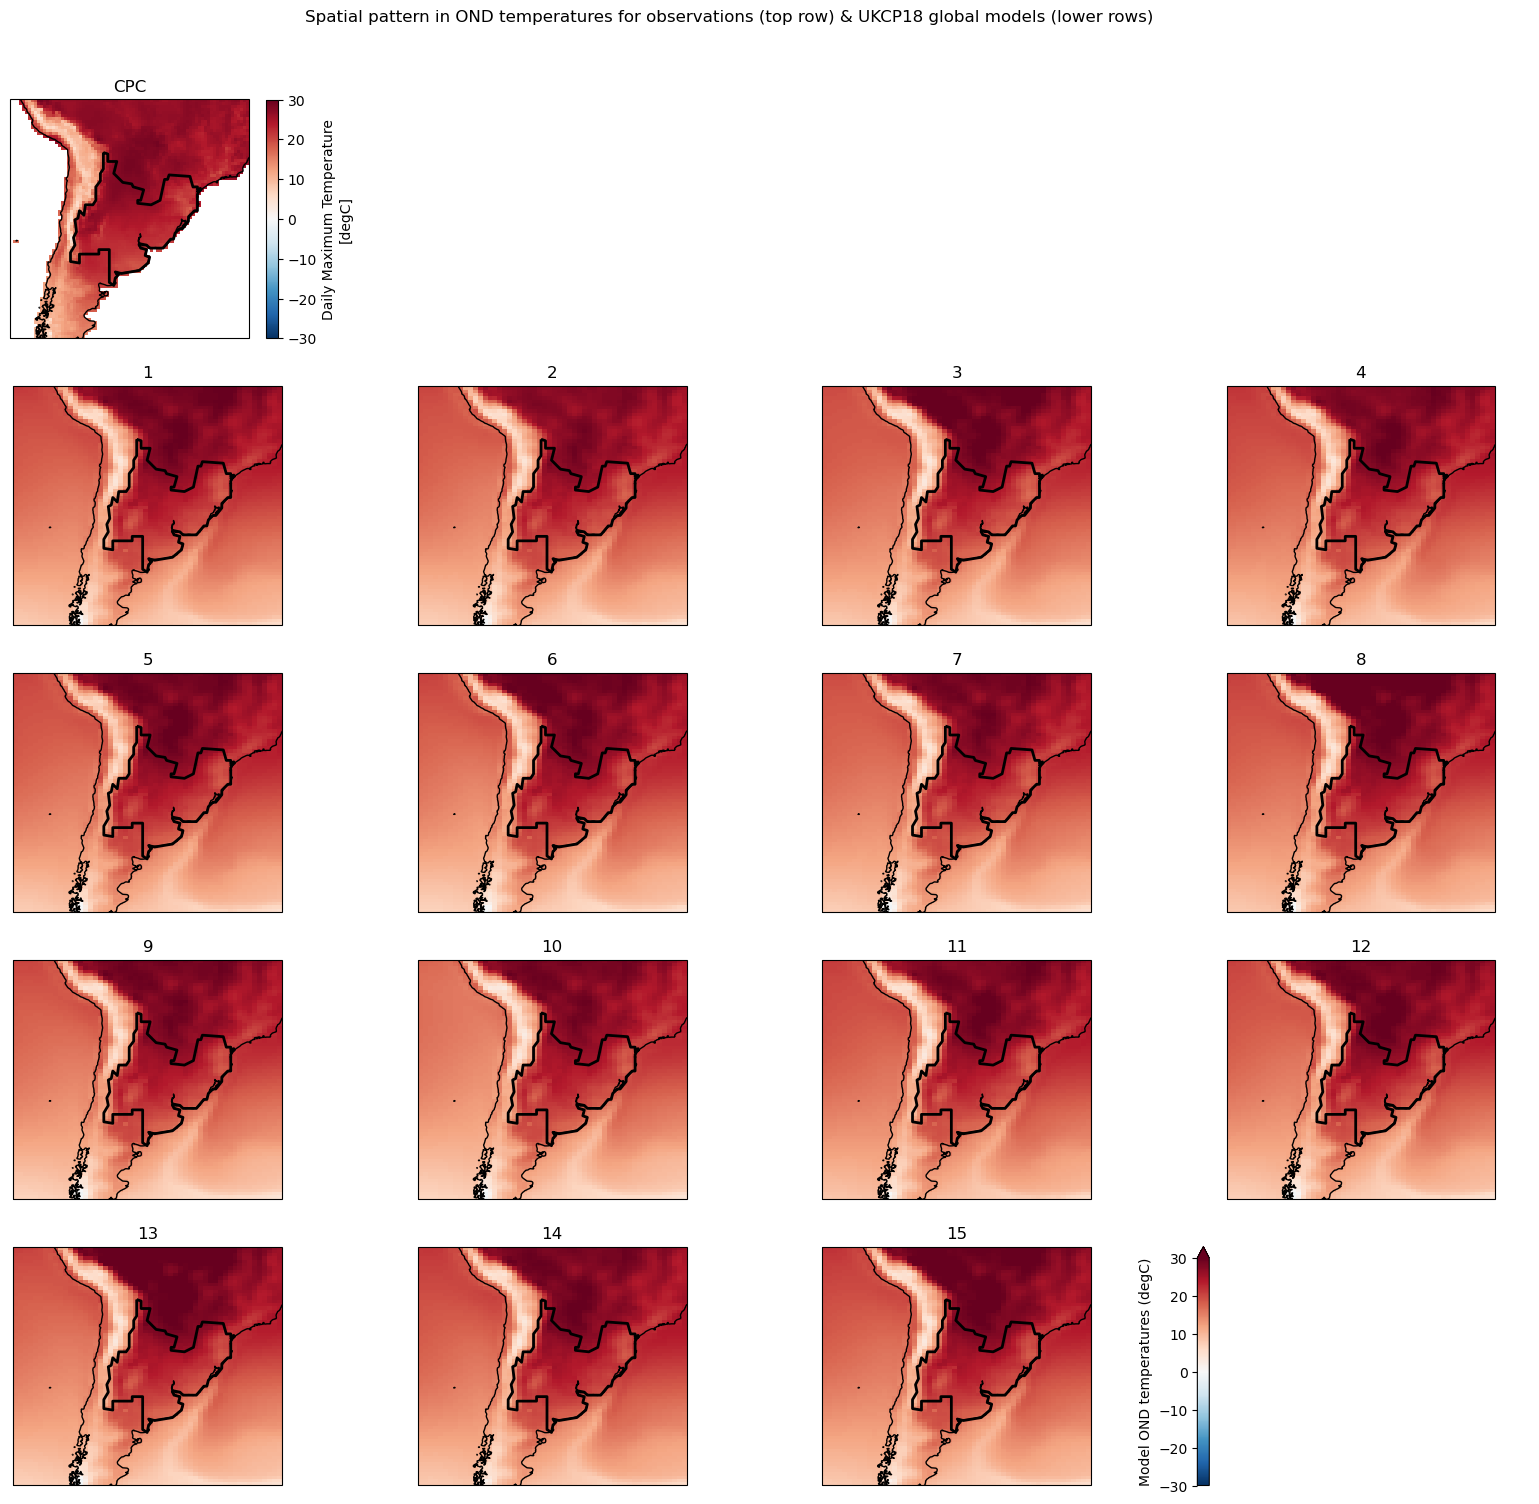

In [155]:
cpc = xr.open_dataset("data/cpc_tas_monthly.nc").tas.rolling(time = 3).mean().groupby("time.month")[1].dropna("time", "all").sel(time = slice("1980", None)).mean("time")

models = xr.open_mfdataset("data/tas_ukcp*_spatial*.nc").tas

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

fig, axs = plt.subplots(ncols = 4, nrows = 5, figsize = (20,18), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

plot_kwargs = {"vmin" : -30, "vmax" : 30, "cmap" : "RdBu_r"}

for ax in axs[0,1:]: ax.set_axis_off()
cpc.plot(ax = axs[0,0], **plot_kwargs)
axs[0,0].coastlines()
axs[0,0].set_title("CPC")
sf.boundary.plot(ax = axs[0,0], color = "k", lw = 2)
    
for i in range(len(models)):
    ax = fig.axes[i+4]
    pr = models[i].squeeze()
    cbar_mdl = ax.pcolormesh(pr.longitude, pr.latitude, pr, **plot_kwargs)
    ax.set_title(pr.ensemble_member.values)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)

for i in range(len(models)+4,20):
    fig.axes[i].set_axis_off()

plt.colorbar(cbar_mdl, ax = axs[-1,-1], location = "left", fraction = 0.05, pad = -0.5, extend = "max", label = "Model OND temperatures (degC)")

plt.suptitle("Spatial pattern in OND temperatures for observations (top row) & UKCP18 global models (lower rows)", y = 0.93)
plt.savefig("ukcp_tas-ond_spatial-patterns.png")

#### **Soil moisture**

In [25]:
cpc_tas = xr.open_dataset("data/cpc_tas_monthly.nc").tas.rolling(time = 3).mean().groupby("time.month")[1].dropna("time", "all").sel(time = slice("1980", None)).mean("time")
cpc_pr = xr.open_dataset("data/cpc_precip_monthly.nc").precip.rolling(time = 3).mean().groupby("time.month")[12].dropna("time", "all").sel(time = slice("1980", None)).mean("time")

models_sfc = xr.open_mfdataset("data/mrso_ukcp*_spatial*.nc").mrso.sel(depth = 0.05)
models_rz = xr.open_mfdataset("data/mrso_ukcp*_spatial*.nc").mrso.sel(depth = [0.05, 0.225, 0.675]).mean("depth")

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

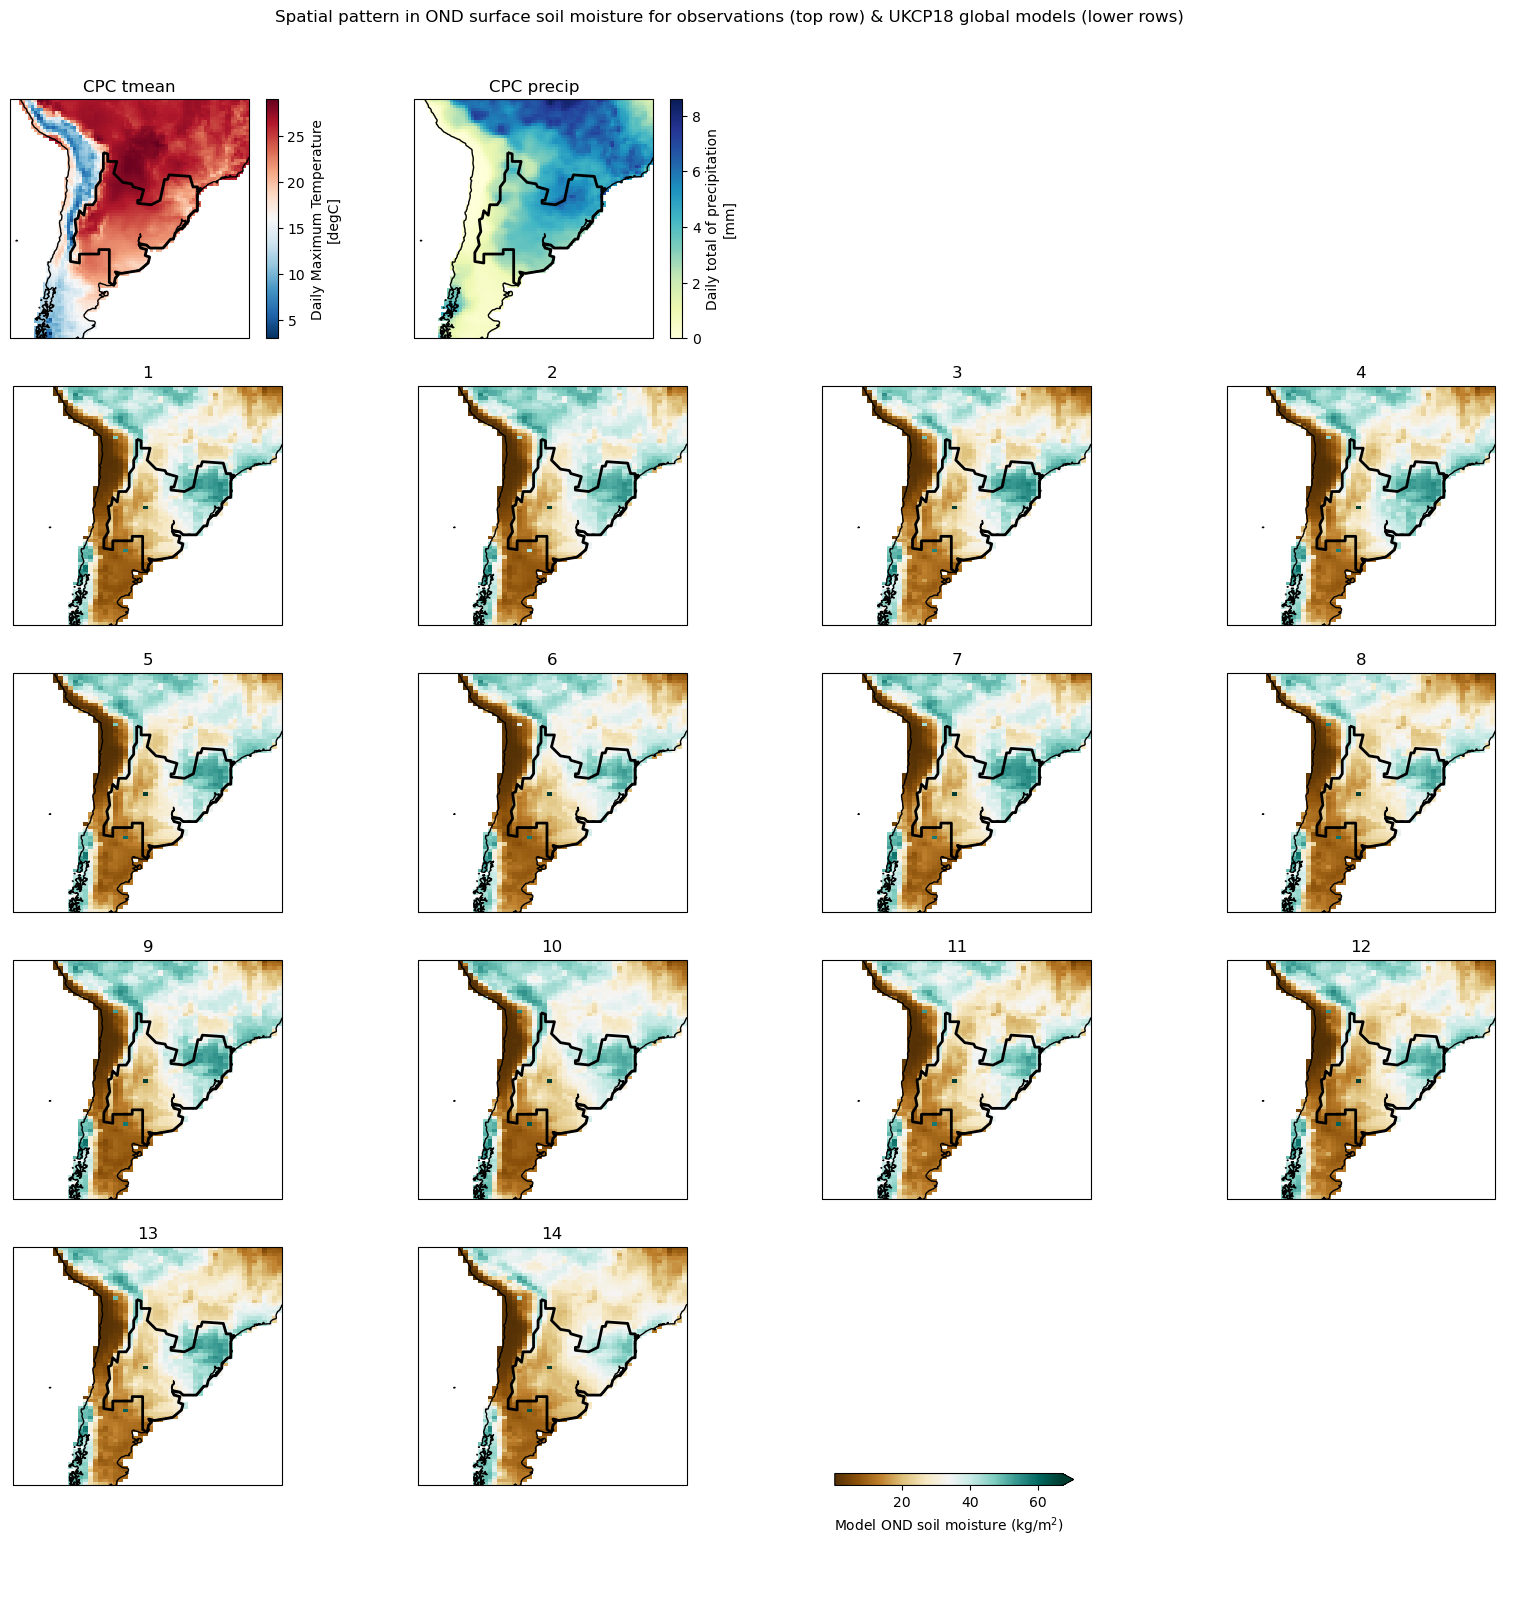

In [19]:
fig, axs = plt.subplots(ncols = 4, nrows = 5, figsize = (20,18), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

plot_kwargs = {"cmap" : "RdBu_r"}

cpc_tas.plot(ax = axs[0,0], cmap = "RdBu_r"); axs[0,0].set_title("CPC tmean")
cpc_pr.plot(ax = axs[0,1], cmap = "YlGnBu", vmin = 0); axs[0,1].set_title("CPC precip")

for ax in axs[0,:2]: ax.coastlines(); sf.boundary.plot(ax = ax, color = "k", lw = 2)
for ax in axs[0,2:]: ax.set_axis_off()
   
for i in range(len(models)):
    ax = fig.axes[i+4]
    sfc = models_sfc[i].squeeze()
    cbar_mdl = sfc.plot(ax = ax, cmap = "BrBG", add_colorbar = False, vmin = 0, vmax = 60)
    ax.set_title(sfc.ensemble_member.values)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)

for i in range(len(models)+4,20):
    fig.axes[i].set_axis_off()

plt.colorbar(cbar_mdl, ax = axs[-1,-2], location = "bottom", fraction = 0.05, pad = -0.5, label = "Model OND soil moisture (kg/m$^2$)")

plt.suptitle("Spatial pattern in OND surface soil moisture for observations (top row) & UKCP18 global models (lower rows)", y = 0.93)
plt.savefig("ukcp_mrso-sfc-ond_spatial-patterns.png")

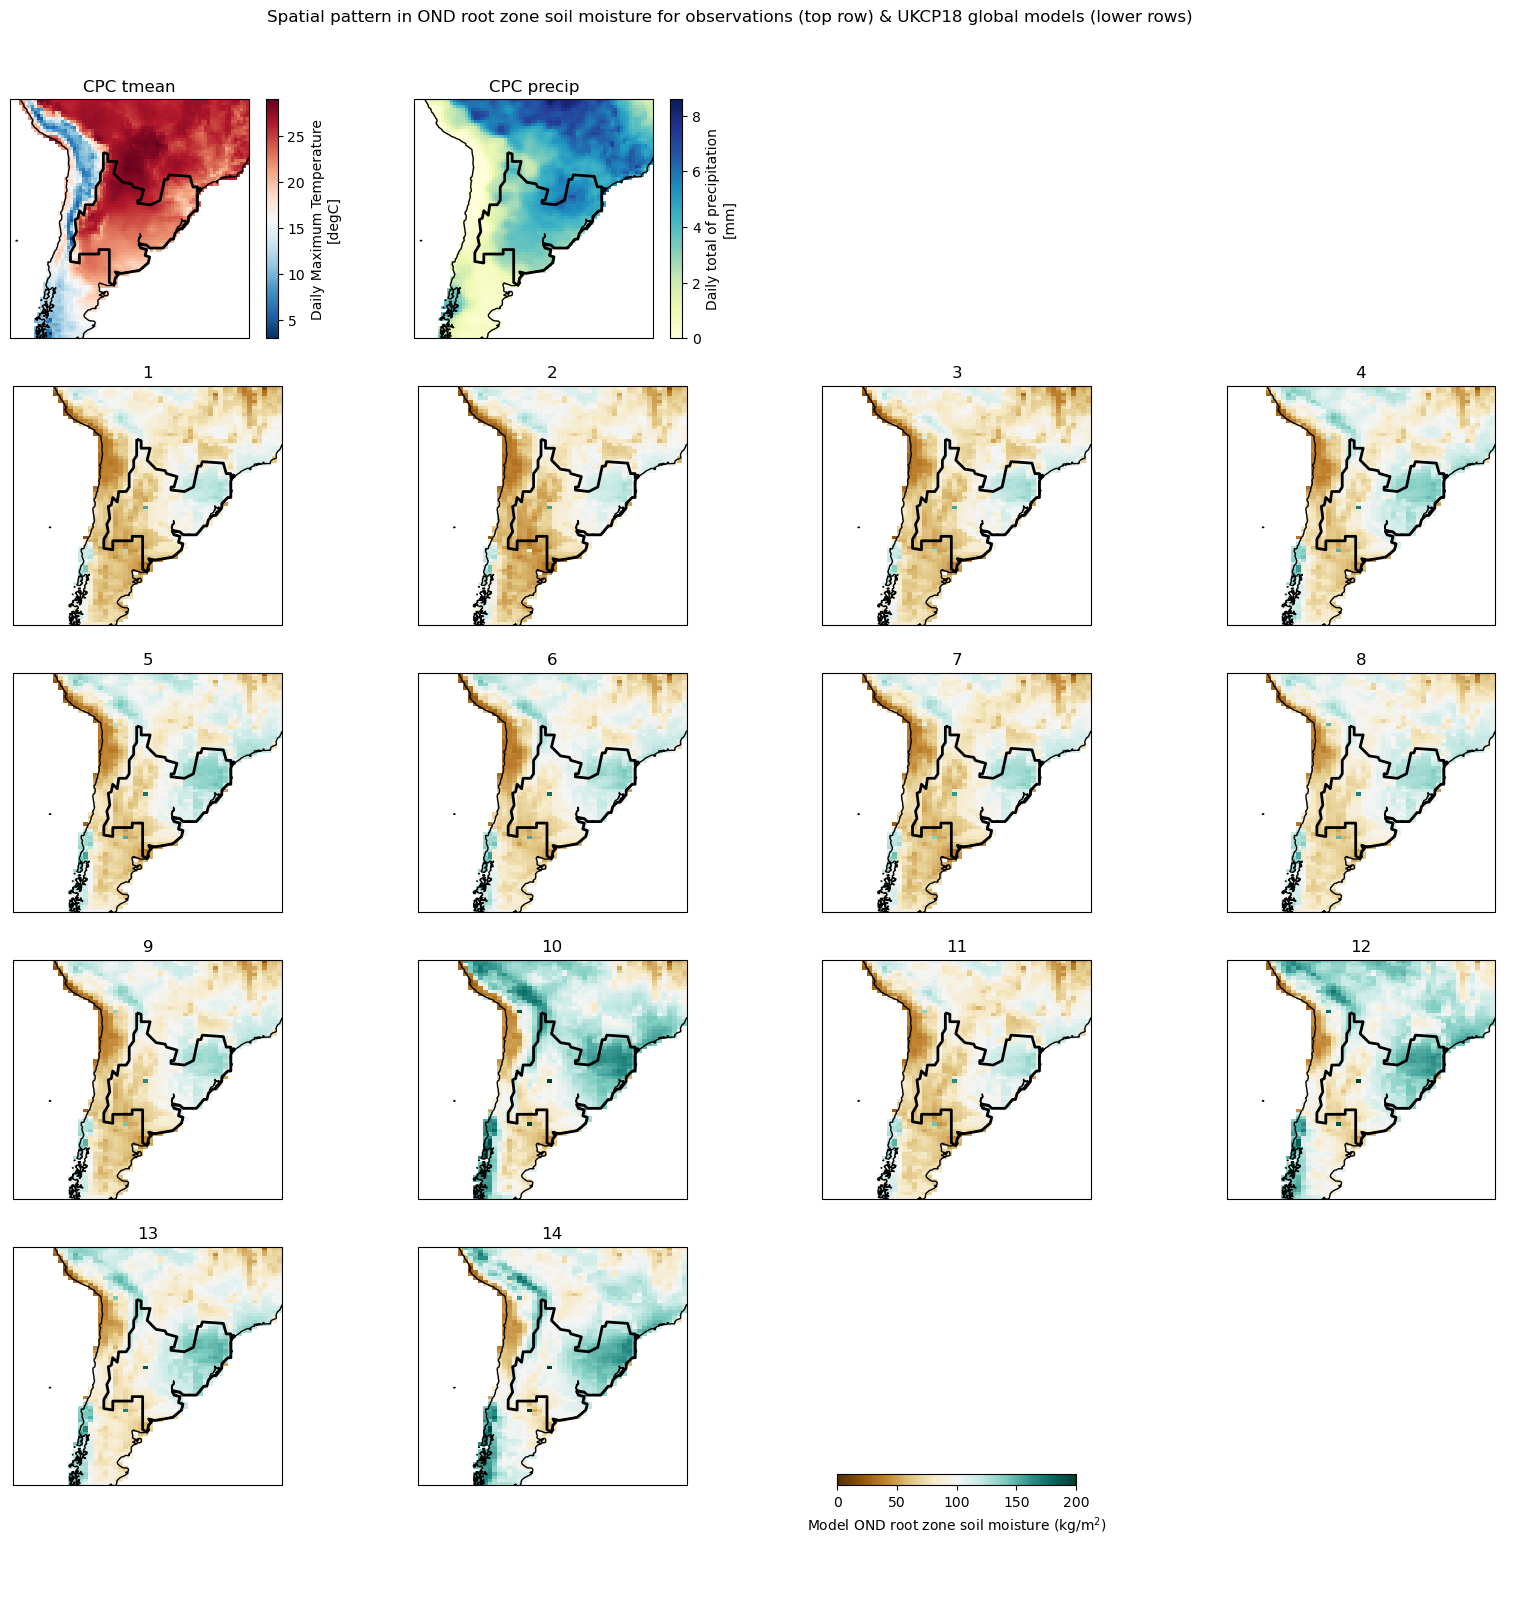

In [29]:
fig, axs = plt.subplots(ncols = 4, nrows = 5, figsize = (20,18), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

plot_kwargs = {"cmap" : "RdBu_r"}

cpc_tas.plot(ax = axs[0,0], cmap = "RdBu_r"); axs[0,0].set_title("CPC tmean")
cpc_pr.plot(ax = axs[0,1], cmap = "YlGnBu", vmin = 0); axs[0,1].set_title("CPC precip")

for ax in axs[0,:2]: ax.coastlines(); sf.boundary.plot(ax = ax, color = "k", lw = 2)
for ax in axs[0,2:]: ax.set_axis_off()
   
for i in range(len(models)):
    ax = fig.axes[i+4]
    sfc = models_rz[i].squeeze()
    cbar_mdl = sfc.plot(ax = ax, cmap = "BrBG", add_colorbar = False, vmin = 0, vmax = 200)
    ax.set_title(sfc.ensemble_member.values)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)

for i in range(len(models)+4,20):
    fig.axes[i].set_axis_off()

plt.colorbar(cbar_mdl, ax = axs[-1,-2], location = "bottom", fraction = 0.05, pad = -0.5, label = "Model OND root zone soil moisture (kg/m$^2$)")

plt.suptitle("Spatial pattern in OND root zone soil moisture for observations (top row) & UKCP18 global models (lower rows)", y = 0.93)
plt.savefig("ukcp_mrso-rz-ond_spatial-patterns.png")

---
## **HighResMIP**

### **Time series for climate explorer**

In [41]:
for varnm in ["pr", "effpr", "tas"]:
    for fnm in sorted(glob.glob("ts-raw/"+varnm+"_*highresSST*")):
        
        da = decode_times(xr.open_dataset(fnm, decode_times = False))[varnm]
        
        mdl = fnm.split("_")[1]
        csv_fnm = "ts/CSA-drought_"+varnm+"-ond_highresSST_"+mdl+".dat"
        
        # create extra header lines for upload to Climate Explorer
        if varnm == "pr":
            str1 = "# contact :: HighResMIP "+mdl+" OND precip central South America drought 2023, c.barnes22@imperial.ac.uk"
            str2 = "# precip [mm/day] OND mean precipitation rate at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
            head = "# year precip"
        elif varnm == "effpr":
            str1 = "# contact :: HighResMIP "+mdl+" OND effective precip (pr - evspsbl) central South America drought 2023, c.barnes22@imperial.ac.uk"
            str2 = "# eff_precip [mm/day] OND mean effective precipitation rate at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
            head = "# year eff_precip"
        elif varnm == "pr":
            str1 = "# contact :: HighResMIP "+mdl+" OND tmean central South America drought 2023, c.barnes22@imperial.ac.uk"
            str2 = "# tmean [degC] OND mean temperature at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
            head = "# year tmean"
            
        ! echo "$str1 " > $csv_fnm
        ! echo "$str2" >> $csv_fnm
        ! echo "$head" >> $csv_fnm
        
        da.assign_coords(time = da.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)